In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage

import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import pickle as pkl
import glob

import math

from endgame import hist2d

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
ml = 0.5
lonsample=[(-78.25+ml, -73.75), (-77.25+ml, -72.75), (-75.5+ml, -71.0), (-66.25+ml, -61.75)]

In [5]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [6]:
corr_all

<xarray.Dataset>
Dimensions:    (dayofyear: 365, latitude: 101, longitude: 65)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 ...
  * dayofyear  (dayofyear) int64 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    pval       (dayofyear, latitude, longitude) float64 ...
    r          (dayofyear, latitude, longitude) float64 ...
    slope      (dayofyear, latitude, longitude) float64 ...
    intercept  (dayofyear, latitude, longitude) float64 ...
Attributes:
    years:    [1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 19...

In [7]:
def readERA(var, load=False):
    if load:
        u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_*.nc')[0]).load()
    else:
        u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    #ipdb.set_trace()
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)

    return u200orig

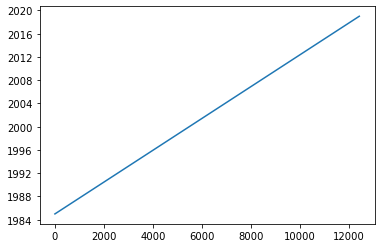

In [8]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).load()
plt.plot(era.time.values)

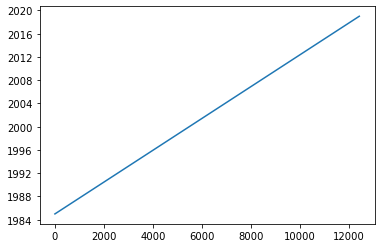

In [9]:
eraq8 = readERA('v550')
eraq8 = eraq8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraq8['time.year']>=1985)&(eraq8['time.year']<=2018))).load()
eravv8 = readERA('u550')
eravv8 = eravv8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eravv8['time.year']>=1985)&(eravv8['time.year']<=2018))).load()
eraqq8 = readERA('q550')
eraqq8 = eraqq8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraqq8['time.year']>=1985)&(eraqq8['time.year']<=2018))).load()*1000

ws = np.sqrt((eraq8['v'].values**2+eravv8['u550'].values**2))
eraq8['v'].values=ws*eraqq8['q550'].values
plt.plot(eraq8.time.values)

In [10]:
del eravv8
del eraqq8

12416


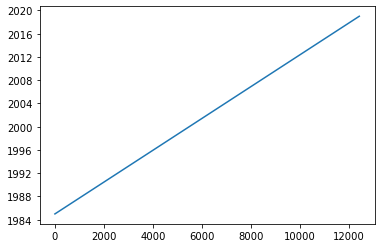

In [11]:
eraT = readERA('tcwv').load()
eraT = eraT['tcwv'].sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraT['time.year']>=1985)&(eraT['time.year']<=2018)))
plt.plot(eraT.time.values)
print(len(eraT.time))

12418


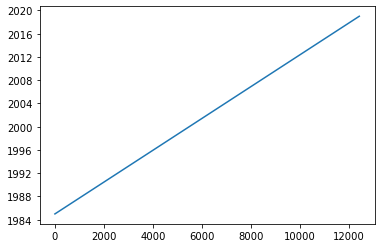

In [12]:
erav = readERA('v850')
erav = erav.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((erav['time.year']>=1985)&(erav['time.year']<=2018))).load()
plt.plot(erav.time.values)
print(len(erav.time))

In [13]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [14]:
eraT = erav.salem.transform(eraT)

In [15]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [16]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-40ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))/100

In [17]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 1500

In [18]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

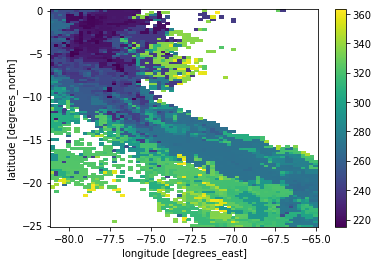

In [19]:
dic['start_3d'].plot()

In [20]:
# lat_pick = corr_all.latitude#.values
# corr_start = dic['start_3d']
# corr_end = dic['end_5d']

# for r in regions.keys():
#     mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
#     sedoy = (np.nanmedian(corr_start.where((topo_on_g>h) & mask)), np.nanmedian(corr_end.where((topo_on_g>h) & mask)))
#     if r == 'southern':
#         plt.pcolormesh(corr_start.where((topo_on_g>h) & mask))
#     print(r, datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[0] - 1), datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[1] ))
#     regions[r].append(sedoy)

In [21]:
# use this, defines narrower season window for region
lat_pick = corr_all.latitude.values
corr_start = dic['start_3d']
corr_end = dic['end_5d']
for r in regions.keys():
    mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
    sedoy = (np.mean(corr_start[mask]).values, np.mean(corr_end[mask]).values)
    #print(r, datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[0] - 1), datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[1] ))
    regions[r].append(sedoy)

In [22]:
#pkl.dump(regions, open("/home/ck/DIR/cornkle/data/HUARAZ/saves/corr_GRIDSAT-15_start_end_regionMean.p", "wb"))

In [23]:
posgridg = np.intersect1d(eraT.time.values, tir_doypick.time.values)

grid200 = tir_doypick.sel(time=posgridg)/100
posgrid = np.intersect1d(chirps_doypick.time.values, grid200.time.values)
grid200 = grid200.sel(time=posgrid)
posgrid = np.intersect1d(eraq8.time.values, grid200.time.values)

grid200 = grid200.sel(time=posgrid)
u200ca = era.sel(time=posgrid)
cau200 = chirps_doypick.sel(time=posgrid)

In [24]:
v850ca = erav.sel(time=posgrid)
q850ca = eraq8.sel(time=posgrid)
Tca = eraT.sel(time=posgrid)

In [25]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def welch_ttest(x1, x2, alternative):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [80]:
drymeans = {'3': [], '5': [], '7': []}
wetmeans = {'3': [], '5': [], '7': []}
dryall = {'3': [], '5': [], '7': []}
wetall =  {'3': [], '5': [], '7': []}
clim_means =  {'3': [], '5': [], '7': []}

drystd ={'3': [], '5': [], '7': []}
wetstd = {'3': [], '5': [], '7': []}
climstd = {'y': [], 'm': [], 'd': []}
tstats = {'3' : [], '5' : [], '7': [] }

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    for snb in ['3', '5', '7']:
        
    
        #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_v2_perPix_split.p", "rb"))
        dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_v2.p", "rb"))
        #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))

        dd = dic['dry'+snb]
        ww = dic['wet'+snb]

        alls = regions[r]
        doys_s = np.round(alls[1][0])
        doys_e = np.round(alls[1][1])
        era_region = u200ca['u'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load()
        tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
        chirps_region = cau200.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load()
        eraq_region = q850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e)))*1000


        xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
        xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
        xxtc = tcwv_region.mean(['latitude', 'longitude'])
        xxq8 = eraq_region.mean(['latitude', 'longitude'])
        
       
        
        chy = xxch.groupby('time.year').mean().std('year').values
        tcy = xxtc.groupby('time.year').mean().std('year').values
        u2y = xxu2.groupby('time.year').mean().std('year').values
        climstd['y'].append((chy,u2y,tcy))
        
        chm = xxch.resample(time='m').mean().std('time').values
        tcm = xxtc.resample(time='m').mean().std('time').values
        u2m = xxu2.resample(time='m').mean().std('time').values
        climstd['m'].append((chm,u2m,tcm))
        
        chd = xxch.std('time').values
        tcd = xxtc.std('time').values
        u2d = xxu2.std('time').values
        climstd['d'].append((chd,u2d,tcd))

        drytir = np.intersect1d(xxch.time.values, dd)
        wettir = np.intersect1d(xxch.time.values, ww)

        xxchd = float(xxch.sel(time=drytir).mean('time').values)
        xxu2d = xxu2.sel(time=drytir)#.mean('time').values)
        xxq8d = xxtc.sel(time=drytir)#.mean('time').values)
        
        dryall[snb].append( (xxch.sel(time=drytir).values, xxu2.sel(time=drytir).values,  xxtc.sel(time=drytir).values) )
        wetall[snb].append( (xxch.sel(time=wettir).values, xxu2.sel(time=wettir).values,  xxtc.sel(time=wettir).values) )
        clim_means[snb].append((xxch.mean('time').values, xxu2.mean('time').values,  xxtc.mean('time').values))

        xxchw = float(xxch.sel(time=wettir).mean('time').values)
        xxu2w = xxu2.sel(time=wettir)#.mean('time').values)
        xxq8w = xxtc.sel(time=wettir)#.mean('time').values)
                      
        pdu =  welch_ttest(xxu2w.values, xxu2d.values, "equal") 
        pdt =  welch_ttest(xxq8w.values, xxq8d.values, "equal") 
                      
        #ipdb.set_trace()
                      
        xxu2d = float(xxu2d.mean('time').values)
        xxu2w = float(xxu2w.mean('time').values)
        xxq8w = float(xxq8w.mean('time').values)
        xxq8d = float(xxq8d.mean('time').values)

        xxchds = float(xxch.sel(time=drytir).std('time').values)
        xxu2ds = float(xxu2.sel(time=drytir).std('time').values)
        xxq8ds = float(xxtc.sel(time=drytir).std('time').values)

        xxchws = float(xxch.sel(time=wettir).std('time').values)
        xxu2ws = float(xxu2.sel(time=wettir).std('time').values)
        xxq8ws = float(xxtc.sel(time=wettir).std('time').values)


        drymeans[snb].append( (xxchd, xxu2d, xxq8d) )
        wetmeans[snb].append( (xxchw, xxu2w, xxq8w ) )
        drystd[snb].append( (xxchds, xxu2ds, xxq8ds))
        wetstd[snb].append( (xxchws, xxu2ws, xxq8ws ) )
        tstats[snb].append((pdu, pdt))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd0ee79d690>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd0ee79d0d0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fd0ee7bd790>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd0ee80fa90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd0ee7fa2d0>,
 'means': []}

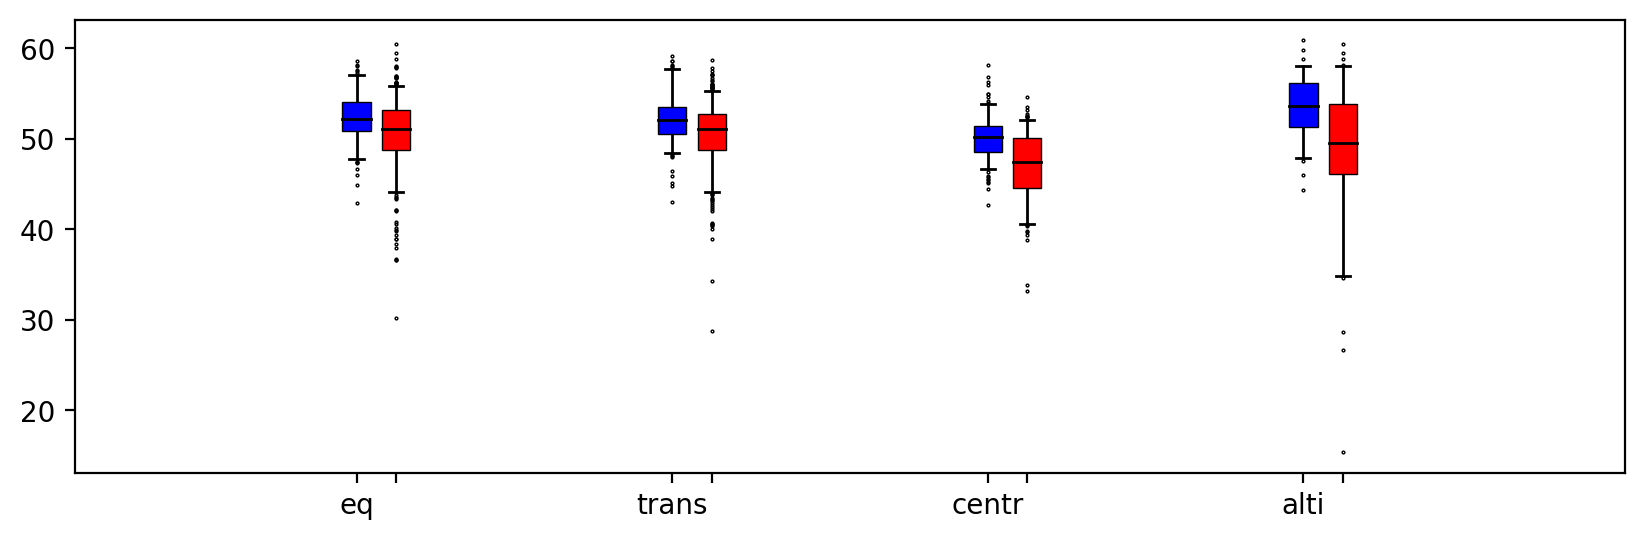

In [27]:
scadir = {}
for ids, r in enumerate(regions.keys()):
    print(r)
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    era_region = u200ca['u'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e)))

    erav_region = v850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e)))
    eraq_region = q850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e)))
    #eraq_region = Tca.where((topo_on_g<1500)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    chirps_region = cau200.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e)))
    #ipdb.set_trace()
    xxch = chirps_region.mean(['latitude', 'longitude']).groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude']).groupby(era_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxv8 = erav_region.mean(['latitude', 'longitude']).groupby(erav_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxq8 = eraq_region.mean(['latitude', 'longitude']).groupby(eraq_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxtcw = tcwv_region.mean(['latitude', 'longitude']).groupby(tcwv_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    
    scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values, xxtcw]
    
allyears = np.unique(xxch['year'])

equatorial
transition
central
southern


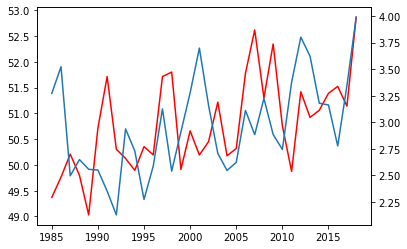

In [28]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(allyears, scadir['southern'][4], color='red')
ax1 = ax.twinx()
ax1.plot(allyears, scadir['southern'][0])

Doing equatorial
slopeuq -0.14267223171132484 0.034972470712814605
trend 1.3833779115727876 0.095213031841654 -1.4267223171132484
(0.1560713249820649, 0.37808854332993713)

Doing transition
slopeuq -0.13515933656060966 0.07243279667202422
trend 0.7820428887608399 0.14078435650119533 -1.3515933656060966
(0.2192994316853819, 0.21271643973552312)

Doing central
slopeuq -0.16295698857014845 0.11727513208430036
trend 0.3931298631124591 0.17270377940854736 -1.6295698857014846
(0.2732228897836491, 0.11794079077240997)

Doing southern
slopeuq -0.12729084154618428 0.007102484880092648
trend -0.21442388559316658 0.22247273799934128 -1.2729084154618429
(0.027115156326439876, 0.8790125707082381)



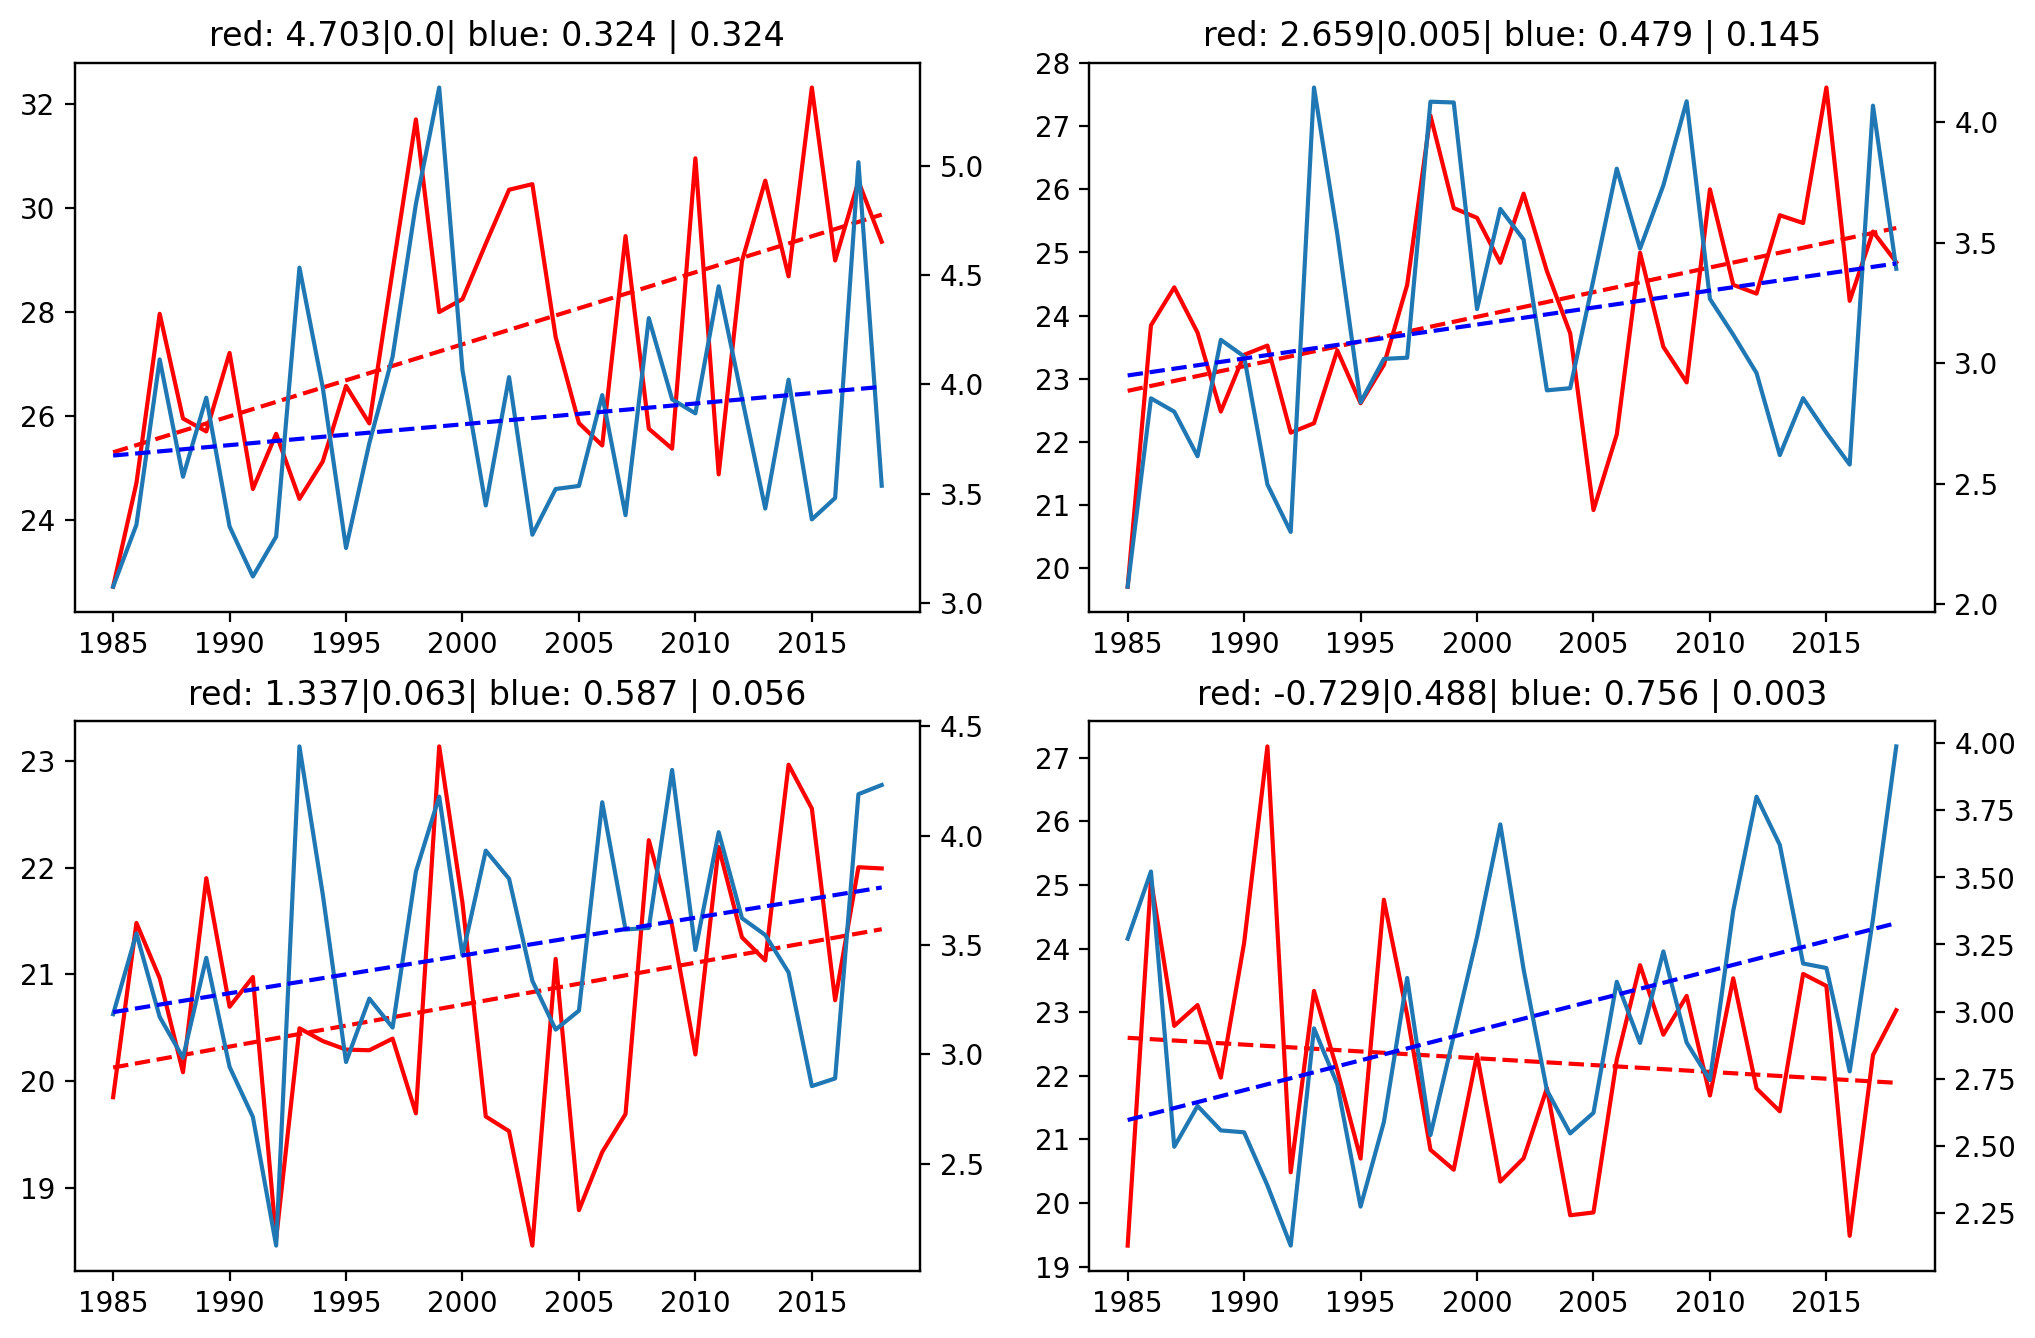

In [29]:
f = plt.figure(figsize=(12,8), dpi=200)
for ids, r in enumerate(regions.keys()):
    
    xnum = 3
    ynum = 0 # rain
    
    var1 = scadir[r][ynum]    # rain
    var2 = scadir[r][xnum]    # 
    var3 = scadir[r][1]
    
    ax = f.add_subplot(2,2,ids+1)
    print('Doing', r)
    ax.plot(allyears,var2, color='r')
    ax1 = ax.twinx()
    ax1.plot(allyears, var1)
    
    
    slopet, interceptt, rrt, pt, k = linregress(allyears, var2)
    slope, intercept, rr, p, k  = linregress(allyears, var1)
    slopeu, dum,dum, dum, dum  = linregress(allyears, var3)
    
    slopeu, dum, dum, dum, dum = linregress(var3, var1)
    slopeq, dum, dum,dum,dum  = linregress(var2, var1)
    
    print('slopeuq', slopeu, slopeq)
    print('trend', slopet*10, slope*10, slopeu*10)
    
    ax.plot(allyears, allyears*slopet+interceptt, linestyle='dashed', color='r')
    ax1.plot(allyears, allyears*slope+intercept, linestyle='dashed', color='b')
    
    plt.title('red: '+str(np.round(slopet*len(allyears),3))+'|'+str(np.round(pt,3))+'| blue: '+str(np.round(slope*len(allyears),3))+' | '+str(np.round(p,3)))
    
    print(stats.pearsonr(var1, var2))
    print()

#     xdiff = scadir[r][xnum][1::] - scadir[r][xnum][0::-1]
#     ydiff = scadir[r][ynum][1::] - scadir[r][ynum][0::-1]
#     slope, intercept, rr, p, se = linregress(xdiff, ydiff)
    
#     ax1.plot(np.array(scadir[r][xnum])*slope+intercept, color='lightblue')
    
#     ax.set_title('wT: r'+str(np.round(rrt,2))+' p '+str(np.round(pt,4))+'  '+str(np.round(rr,2))+' p '+str(np.round(p,4)))

In [30]:
def weighted_regress(bins,data, pval=None):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    weight=None
    if pval is not None:
        inval = np.array(pval)#[pos]
        weight = inval / np.sum(inval)
    X = sm.add_constant(inbins)

    wls_model = sm.WLS(indata,X, missing='drop').fit() # #, weights=weight
    
    r, pval = stats.pearsonr(bins, data)
    
    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    rpearson = r
    ppearson = pval
    return intercept, slope, r_value,rpearson, ppearson

In [31]:
import seaborn as sns
colord = sns.color_palette("magma_r")

In [32]:
from scipy.stats import binned_statistic_2d

def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.725
Model:                            WLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     459.5
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           1.70e-98
Time:                        13:19:04   Log-Likelihood:                -611.34
No. Observations:                 352   AIC:                             1229.
Df Residuals:                     349   BIC:                             1240.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.0435      0.836    -16.804      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.759
Model:                            WLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     481.5
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           3.05e-95
Time:                        13:19:06   Log-Likelihood:                -487.27
No. Observations:                 309   AIC:                             980.5
Df Residuals:                     306   BIC:                             991.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.8450      0.862    -18.383      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.827
Model:                            WLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     646.4
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.14e-103
Time:                        13:19:07   Log-Likelihood:                -380.71
No. Observations:                 273   AIC:                             767.4
Df Residuals:                     270   BIC:                             778.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.8650      0.753    -19.739      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.850
Model:                            WLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     885.7
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          2.30e-129
Time:                        13:19:09   Log-Likelihood:                -365.90
No. Observations:                 315   AIC:                             737.8
Df Residuals:                     312   BIC:                             749.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2165      0.451    -13.774      0.0

Text(0, 4, 'b)')

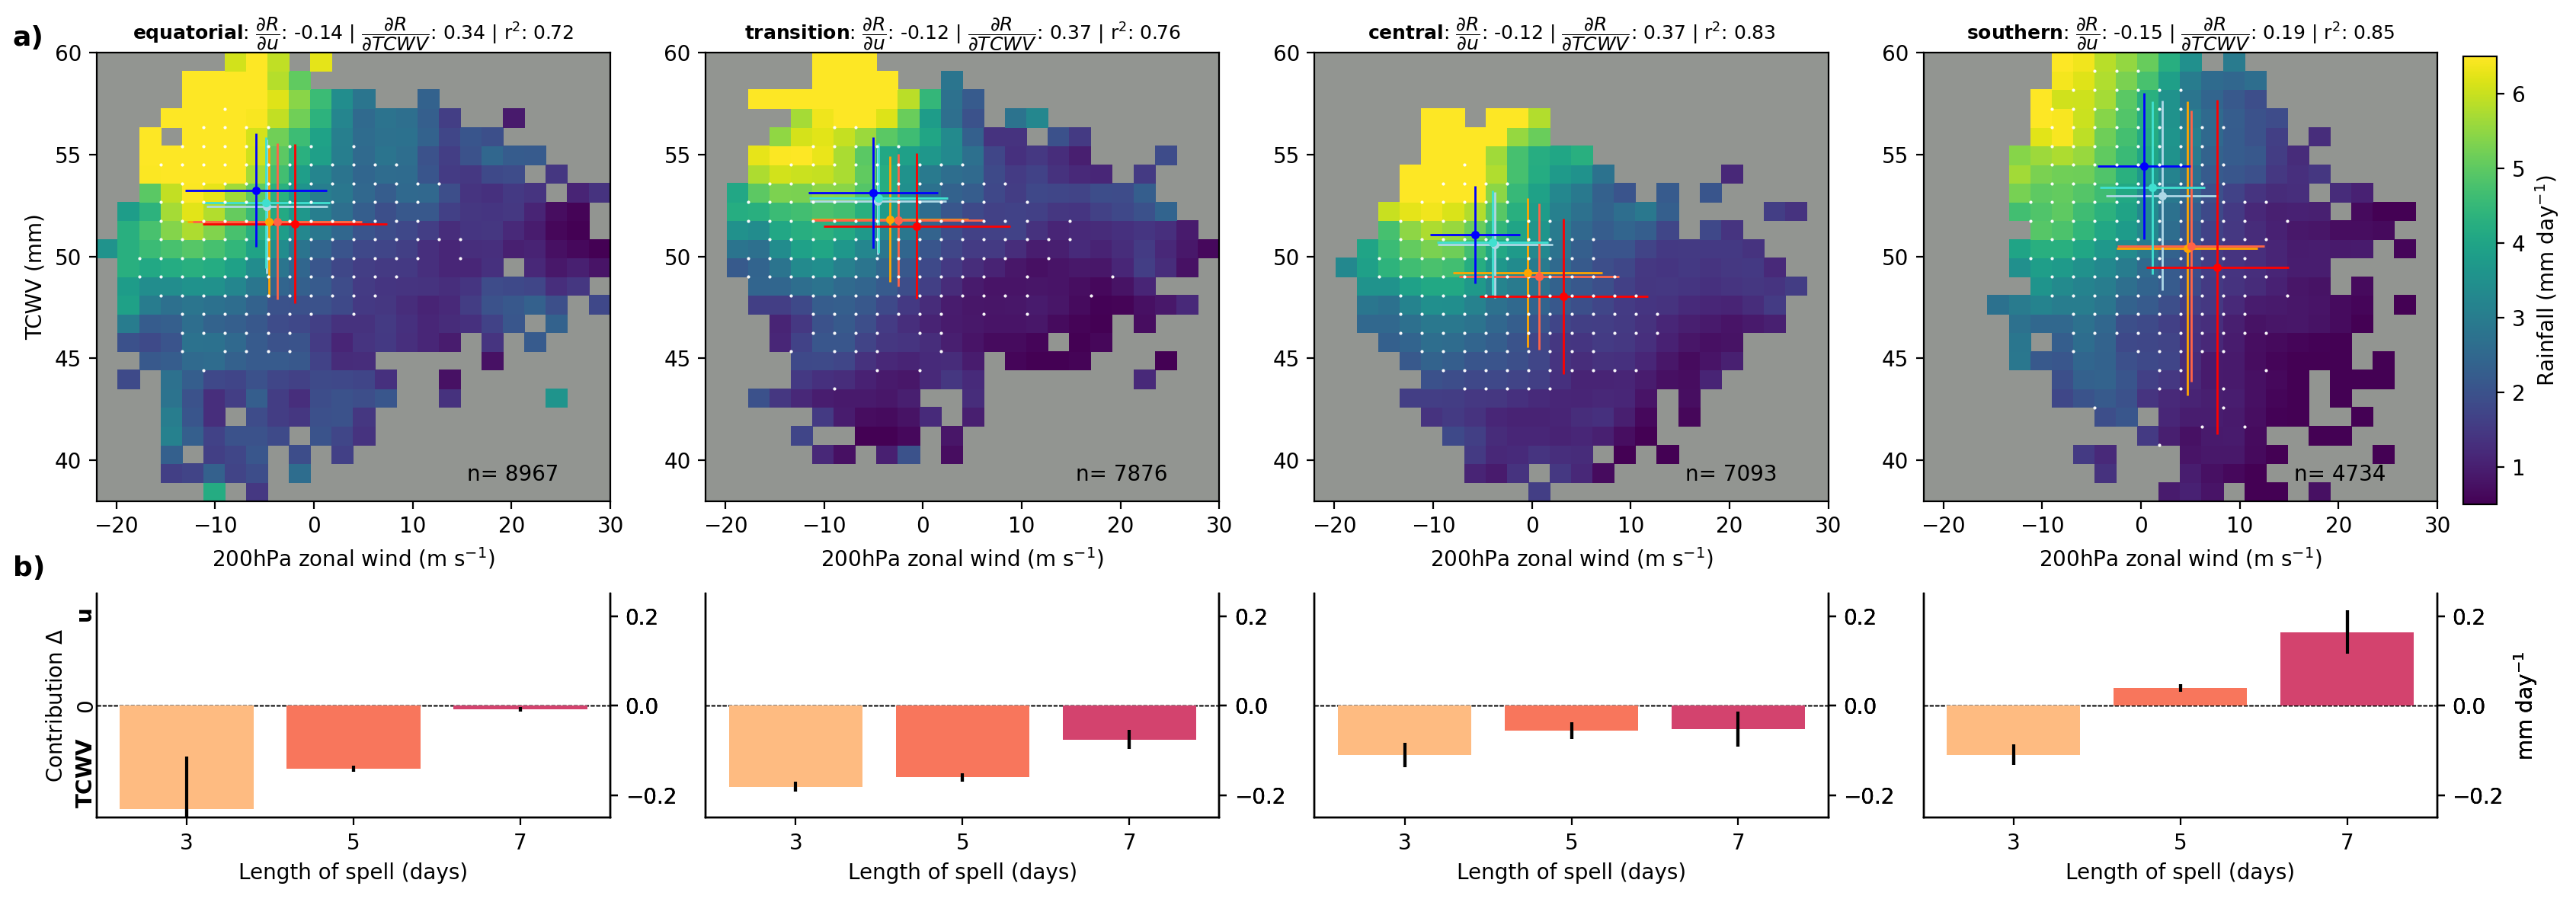

In [75]:
slopes2d = {}  #u, then TCW
# Create 4x4 Grid

f = plt.figure(figsize=(17,6), dpi=200)
gs = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2,1])#, hspace=0.25)
gs2 = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2,1])#, hspace=0.25)#, wspace=0.2)

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))

    erav_region = v850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<h))
    eraq_region = q850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<h))
    tcwv_region = Tca.where((topo_on_g<1500)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    
    
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
    xxv8 = erav_region.mean(['latitude', 'longitude'])#.groupby(erav_region['time.year']).mean()
    xxq8 = eraq_region.mean(['latitude', 'longitude'])#.groupby(eraq_region['time.year']).mean()
    xxtc = tcwv_region.mean(['latitude', 'longitude'])
  #  ipdb.set_trace()


    ax = f.add_subplot(gs[0,ids])

    
    q1 = 0.1
    q2 = 99.9
    sbin = np.linspace(np.percentile(xxu2,q1) ,np.percentile(xxu2,q2),19)
    #tbin = np.linspace(np.percentile(xxq8,q1) ,np.percentile(xxq8,q2),19)
    tbin = np.linspace(np.percentile(xxtc,q1) ,np.percentile(xxtc,q2),19)
    
    tbin = np.linspace(38,60,25)
    sbin = np.linspace(-22,30,25)
    
    p1,p2 = np.percentile(xxch,[10,89])

    testbins = [sbin,tbin]
    func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
    func2 = lambda y: np.sum(np.isfinite(y))
    func3 = lambda y: np.sum(y>1)
    ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
    count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
    thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)
    
    dicobs = run_small_2d(ret, count, testbins)
    
    ax.set_facecolor('xkcd:grey')
    
    cctar=count.statistic.T
    target = np.sum(count.statistic.T)*0.8 # get threshold with 80% of cases 
    
    for cc in np.unique(cctar)[::-1]:
        
        breaker = np.sum(cctar[cctar>=cc])
        if breaker >= target:
            tests = cc
            break
    
    maskpos = np.where(count.statistic.T>=tests)
    dd = gauss(ret.statistic.T, 0.8) #count.statistic.T #gauss(ret.statistic.T, 0.8)
    pixelval=3
    invalid = count.statistic.T < pixelval
    dd[invalid] = np.nan
#     bigpos = np.where(dd>60)
#     print('bigpos', bigpos)
    mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis',vmax=6.5, vmin=0.5) #vmax=p2-1, vmin=0.5  ##p2-1
    plt.plot(testbins[0][maskpos[1]],testbins[1][maskpos[0]],'.', color='white', markersize=1)
    ax.set_yticks(np.arange(40,61,5).astype(int))
    

    
    wcolors = ['lightblue', 'turquoise', 'blue']
    dcolors = ['orange', 'tomato', 'red']
    for sid, snb in enumerate(['3', '5', '7']):
        dreg = drymeans[snb][ids]
        wreg = wetmeans[snb][ids]
        dregstd = drystd[snb][ids]
        wregstd = wetstd[snb][ids]
        plt.errorbar(dreg[1]+1, dreg[2]+1, yerr=dregstd[2], xerr=dregstd[1], color=dcolors[sid], marker='o', elinewidth=1, ms=3)
        plt.errorbar(wreg[1]+1, wreg[2]+1, yerr=wregstd[2], xerr=wregstd[1], color=wcolors[sid], marker='o', elinewidth=1, ms=3)
#     if ids in [3]:
#         plt.colorbar(mp, label='Rainfall (mm day$^{-1}$)')
#     else:
#         plt.colorbar(mp, label='')
    if ids in [0,1,2,3]:
        plt.xlabel( r'200hPa zonal wind (m s$^{-1}$)')  #'200hPa zonal wind (m s$^{-1}$)'
    if ids in [0]:
        plt.ylabel('TCWV (mm)')
    
#     if r == 'southern':
#         dicobs['slope_y']= 0.3674
        
    plt.title( r'$\bf{'+r+'}$'+r': $\dfrac{\partial R}{\partial u}$: '+ str(np.round(dicobs['slope_x'],2)) + \
              r' | $\dfrac{\partial R}{\partial TCWV}$: '+ str(np.round(dicobs['slope_y'],2))+ r' | r$^{2}$: '+str(np.round(dicobs['model'].rsquared,2)), fontsize=9)
    # #+ r'$\pm$'+str(np.round(dicobs['model'].bse[1],2)) + r'$\pm$'+str(np.round(dicobs['model'].bse[2],2))
    plt.xlim(testbins[0][0],testbins[0][-1])
    plt.ylim(testbins[1][0],testbins[1][-1])
   
    #ipdb.set_trace()
    
    
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    #plt.text(15,34.5,'n days='+str(math.trunc(np.sum(count.statistic))))
    plt.text(x_max-14.5,y_min+1,'n= '+str(math.trunc(np.sum(count.statistic))))
    #ipdb.set_trace()
    
    
    slopes2d[r] = (dicobs['slope_x'],dicobs['slope_y'],dicobs['intercept'], dicobs['model'].bse[1], dicobs['model'].bse[2]) 
    
    df = pd.DataFrame.from_dict(slopes2d)
    df.to_csv('/home/ck/DIR/cornkle/data/HUARAZ/saves/scaling_TCW_uwind_from2dhist.csv')

    
################################# bottom plot    
    
#ax1 = f.add_subplot(gs2[2,:])
shi = [-0.1,0,0.1,0.2]
step = [0, 0.25, 0.5]



for ids, r in enumerate(regions.keys()):
    for dnid, dnb in enumerate(['3','5', '7']):

#         dreg = drymeans[dnb][ids]
#         wreg = wetmeans[dnb][ids]
#         dregstd = drystd[dnb][ids]
#         wregstd = wetstd[dnb][ids]

        ax1 = f.add_subplot(gs[1,ids])

        u2stats  = tstats[dnb][ids][0]
        tcstats = tstats[dnb][ids][1]

        statsi = slopes2d[r]
        slopeu = statsi[0]
        slopet = statsi[1]
        inter = statsi[2]

        erru = statsi[3]
        errt = statsi[4]
        #ipdb.set_trace()
        um = u2stats["Difference in mean"] *slopeu
        tm = tcstats["Difference in mean"] *slopet
        
        erru = np.vstack(((abs(u2stats["Difference in mean"])-abs(u2stats["lb"]))*slopeu,  (abs(u2stats["ub"])-abs(u2stats["Difference in mean"]))*slopeu))
        errt = np.vstack(((abs(tcstats["Difference in mean"])-abs(tcstats["lb"]))*slopet,  (abs(tcstats["ub"])-abs(tcstats["Difference in mean"]))*slopet))
        #ipdb.set_trace()
        upval = u2stats["pvalue 2 sided"].values
        tpval = tcstats["pvalue 2 sided"].values
        
        mdiff = um-tm
        #ipdb.set_trace()
        errdiff = np.max(np.array([erru[0]-errt[1], errt[0]-erru[1]]))/2
        #ub = u2stats["ub"]*slopeu - tcstats["ub"]*slopet)
        
        #errs = np.vstack((lb,ub))
        
        if upval <=0.05:
            uecol = 'k'
        else:
            uecol = 'grey'
        if tpval <=0.05:
            tecol = 'k'
        else:
            tecol = 'grey'

        #ipdb.set_trace()
#         bar1 = ax1.bar(ids+shi[0]+step[dnid], um, color='r', width=0.1, yerr=erru, linewidth=0.5, ecolor=uecol)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], tm, color='lightblue', width=0.1, yerr=errt, ecolor=tecol)



#         bar1 = ax1.bar(ids+shi[0]+step[dnid], (wreg[1]-dreg[1])*slopeu, color='r', width=0.1, yerr=((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu), linewidth=0.5)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], (wreg[2]-dreg[2])*slopet, color='lightblue', width=0.1, yerr=((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet))

#         ub = (wreg[1]-dreg[1])*slopeu
#         tb = (wreg[2]-dreg[2])*slopet
#         udiff = ((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu)
#         tdiff = ((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet)

#         if mdiff < 0:
#             col = 'lightblue'
#         else:
#             col = 'grey'
        if ids == 0:
            lab = dnb+'-day spell'
        else:
            lab = ''
        bar2 = ax1.bar(0+step[dnid], mdiff, color=colord[dnid], width=0.2, yerr=errdiff, label=lab)

        ax1.axhline(0, linestyle='dashed', color='k', linewidth=0.5)
        ax1.set_ylim(-0.25,0.25)
        ax1.set_xticks(step)
        ax1.set_xticklabels(['3', '5', '7'])
        ax1.set_xlabel('Length of spell (days)')
        if ids == 0:
            ax1.set_ylabel('Contribution $\Delta$')
            ax1.set_yticks([-0.15, 0, 0.2])
            ax1.set_yticklabels([r'$\bf{TCWV}$', '0', r'$\bf{u}$'], rotation=90, ha='center', rotation_mode='anchor')
            ax1.tick_params(axis='y', length=0, pad=6)
        else:
            ax1.set_yticks([])
        ax1.spines['top'].set_visible(False)
        
        
        ax2 = ax1.twinx()
        ax2.bar(0+step[dnid], mdiff, color=colord[dnid], width=0.2, yerr=errdiff, label=lab)
        ax2.set_yticks([-0.2, 0, 0.2])
        ax2.set_ylim(-0.25,0.25)
        ax2.spines['top'].set_visible(False)
        if ids ==3:
            ax2.set_ylabel('mm day$^{-1}$')

        #ax1.margins(x=1)
#     if ids == 0:
#         plt.legend(loc='upper left', fontsize=8, bbox_to_anchor=(0.01, 1.3), framealpha=1)
   
#plt.subplots_adjust(wspace=0.11, hspace=0.15)   
plt.tight_layout()

f.subplots_adjust(right=0.94)
cax = f.add_axes([0.95,0.44,0.013,0.49])
f.colorbar(mp, cax, label='Rainfall (mm day$^{-1}$)')
#plt.tight_layout()
#cbar = f.colorbar(mapp, cax, format='%1.1f',label=r'g kg$^{-1}$')
plt.annotate('a)', xy=(0.005, 0.94), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.005, 0.35), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/tcw_u200_2dhist_origSpells_v3.jpg')

In [112]:
wet_rscat_tcw = []
dry_rscat_tcw = []
wet_rscat_u = []
dry_rscat_u = []
both_wet = []
both_dry = []
snb = '3'
varidt = 2
varidu = 1
for ids, r in enumerate(regions.keys()):
   # for sid, snb in enumerate(['3', '5', '7']): # rain, u, tcw
        
        tscale = df[r][1]
        uscale = df[r][0]
        tint = df[r][3]
        uint = df[r][2]
        
        dry_rscat_tcw.append((dryall[snb][ids][varidt]-clim_means[snb][ids][varidt])*tscale)
        wet_rscat_tcw.append((wetall[snb][ids][varidt]-clim_means[snb][ids][varidt])*tscale)
        dry_rscat_u.append((dryall[snb][ids][varidu]-clim_means[snb][ids][varidu])*uscale)
        wet_rscat_u.append((wetall[snb][ids][varidu]-clim_means[snb][ids][varidu])*uscale)
        
        both_wet.append(((wetall[snb][ids][varidt]-clim_means[snb][ids][varidt])*tscale ) - ((wetall[snb][ids][varidu]-clim_means[snb][ids][varidu])*uscale))
        both_dry.append( ((dryall[snb][ids][varidt]-clim_means[snb][ids][varidt])*tscale)  - ((dryall[snb][ids][varidu]-clim_means[snb][ids][varidu])*uscale) )

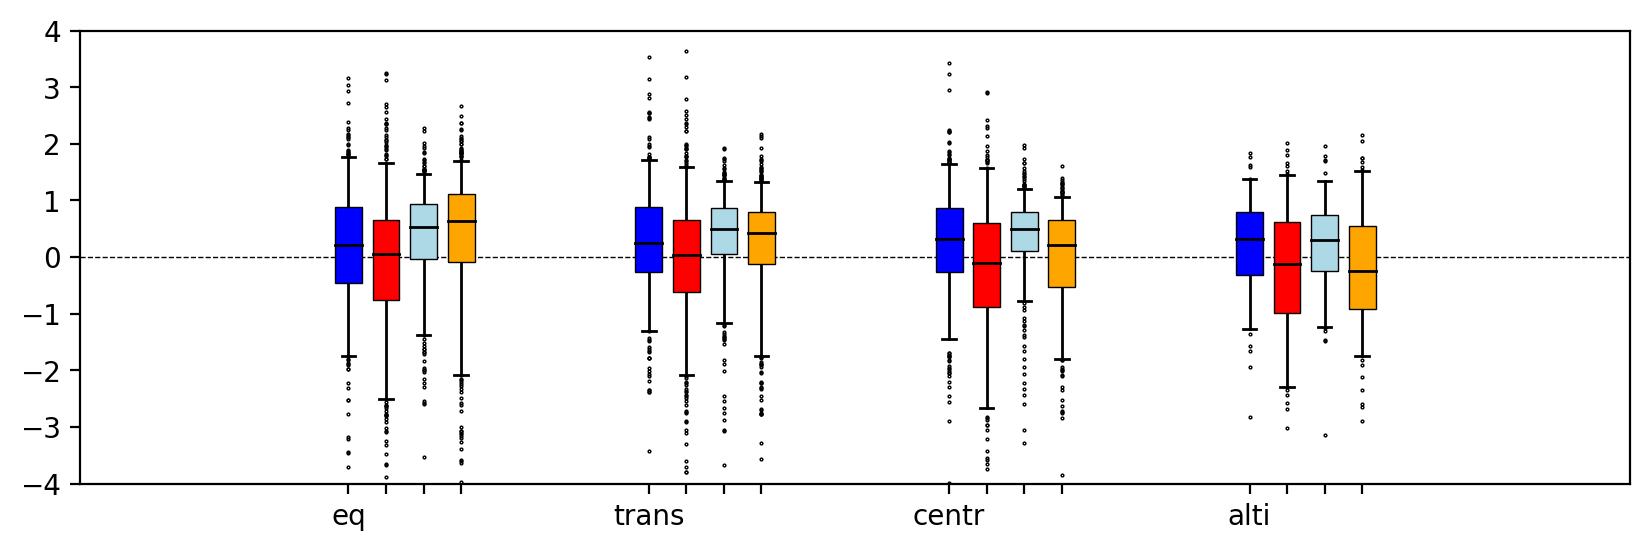

In [113]:
f = plt.figure(figsize=(10,3), dpi=200)
ids = 1
labels=['eq', 'trans', 'centr', 'alti']
bpos = np.linspace(0.45,2.13,len(labels))
ax = f.add_subplot(111)
cnt = 0

ax.boxplot(wet_rscat_tcw, positions=bpos, labels=labels, whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='blue', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.boxplot(dry_rscat_tcw, positions=bpos+0.07, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='red', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.boxplot(wet_rscat_u, positions=bpos+0.14, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='lightblue', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.boxplot(dry_rscat_u, positions=bpos+0.21, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='orange', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.set_ylim(-4,4)
ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
# for qw, qd in zip(wet_rscat[var],dry_rscat[var]):
#     print(stats.ttest_ind(qw, qd, equal_var=False))

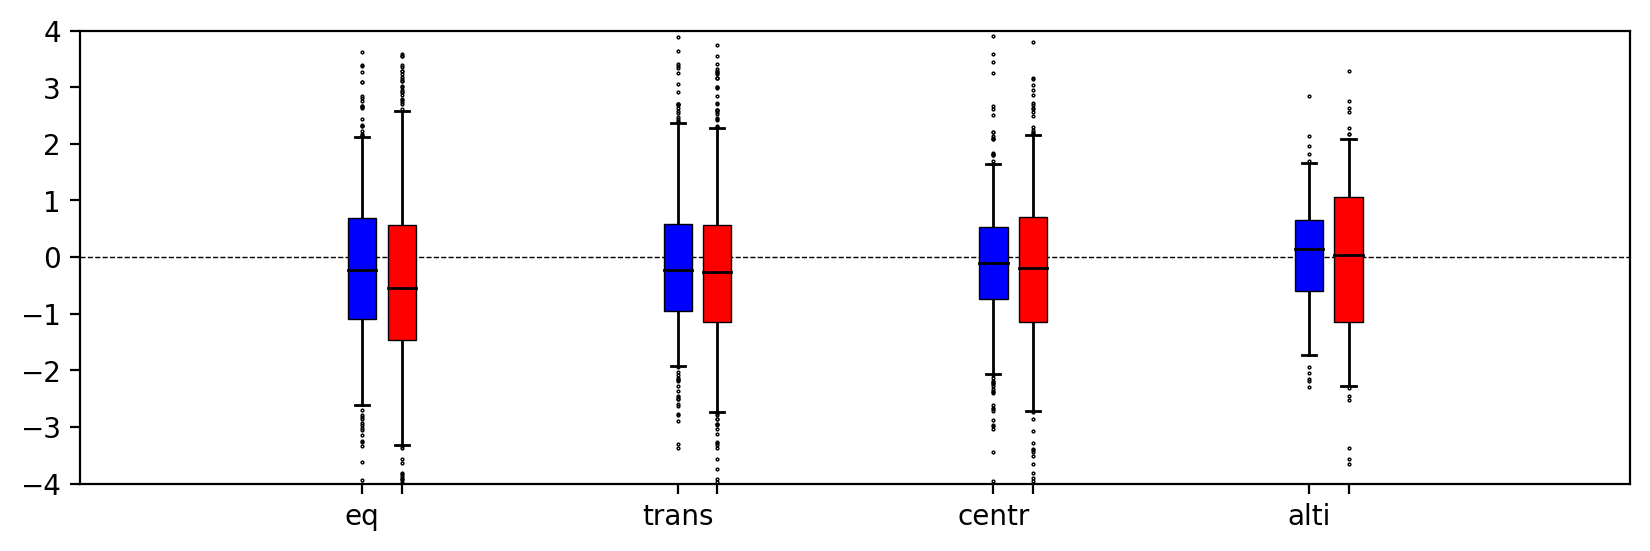

In [114]:
f = plt.figure(figsize=(10,3), dpi=200)
ids = 1
labels=['eq', 'trans', 'centr', 'alti']
bpos = np.linspace(0.45,2.13,len(labels))
ax = f.add_subplot(111)
cnt = 0

ax.boxplot(both_wet, positions=bpos, labels=labels, whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='blue', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.boxplot(both_dry, positions=bpos+0.07, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='red', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
# ax.boxplot(wet_rscat_u, positions=bpos+0.14, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='lightblue', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
# ax.boxplot(dry_rscat_u, positions=bpos+0.21, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='orange', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.set_ylim(-4,4)
ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
# for qw, qd in zip(wet_rscat[var],dry_rscat[var]):
#     print(stats.ttest_ind(qw, qd, equal_var=False))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: 

IndexError: index 2 is out of bounds for axis 0 with size 2

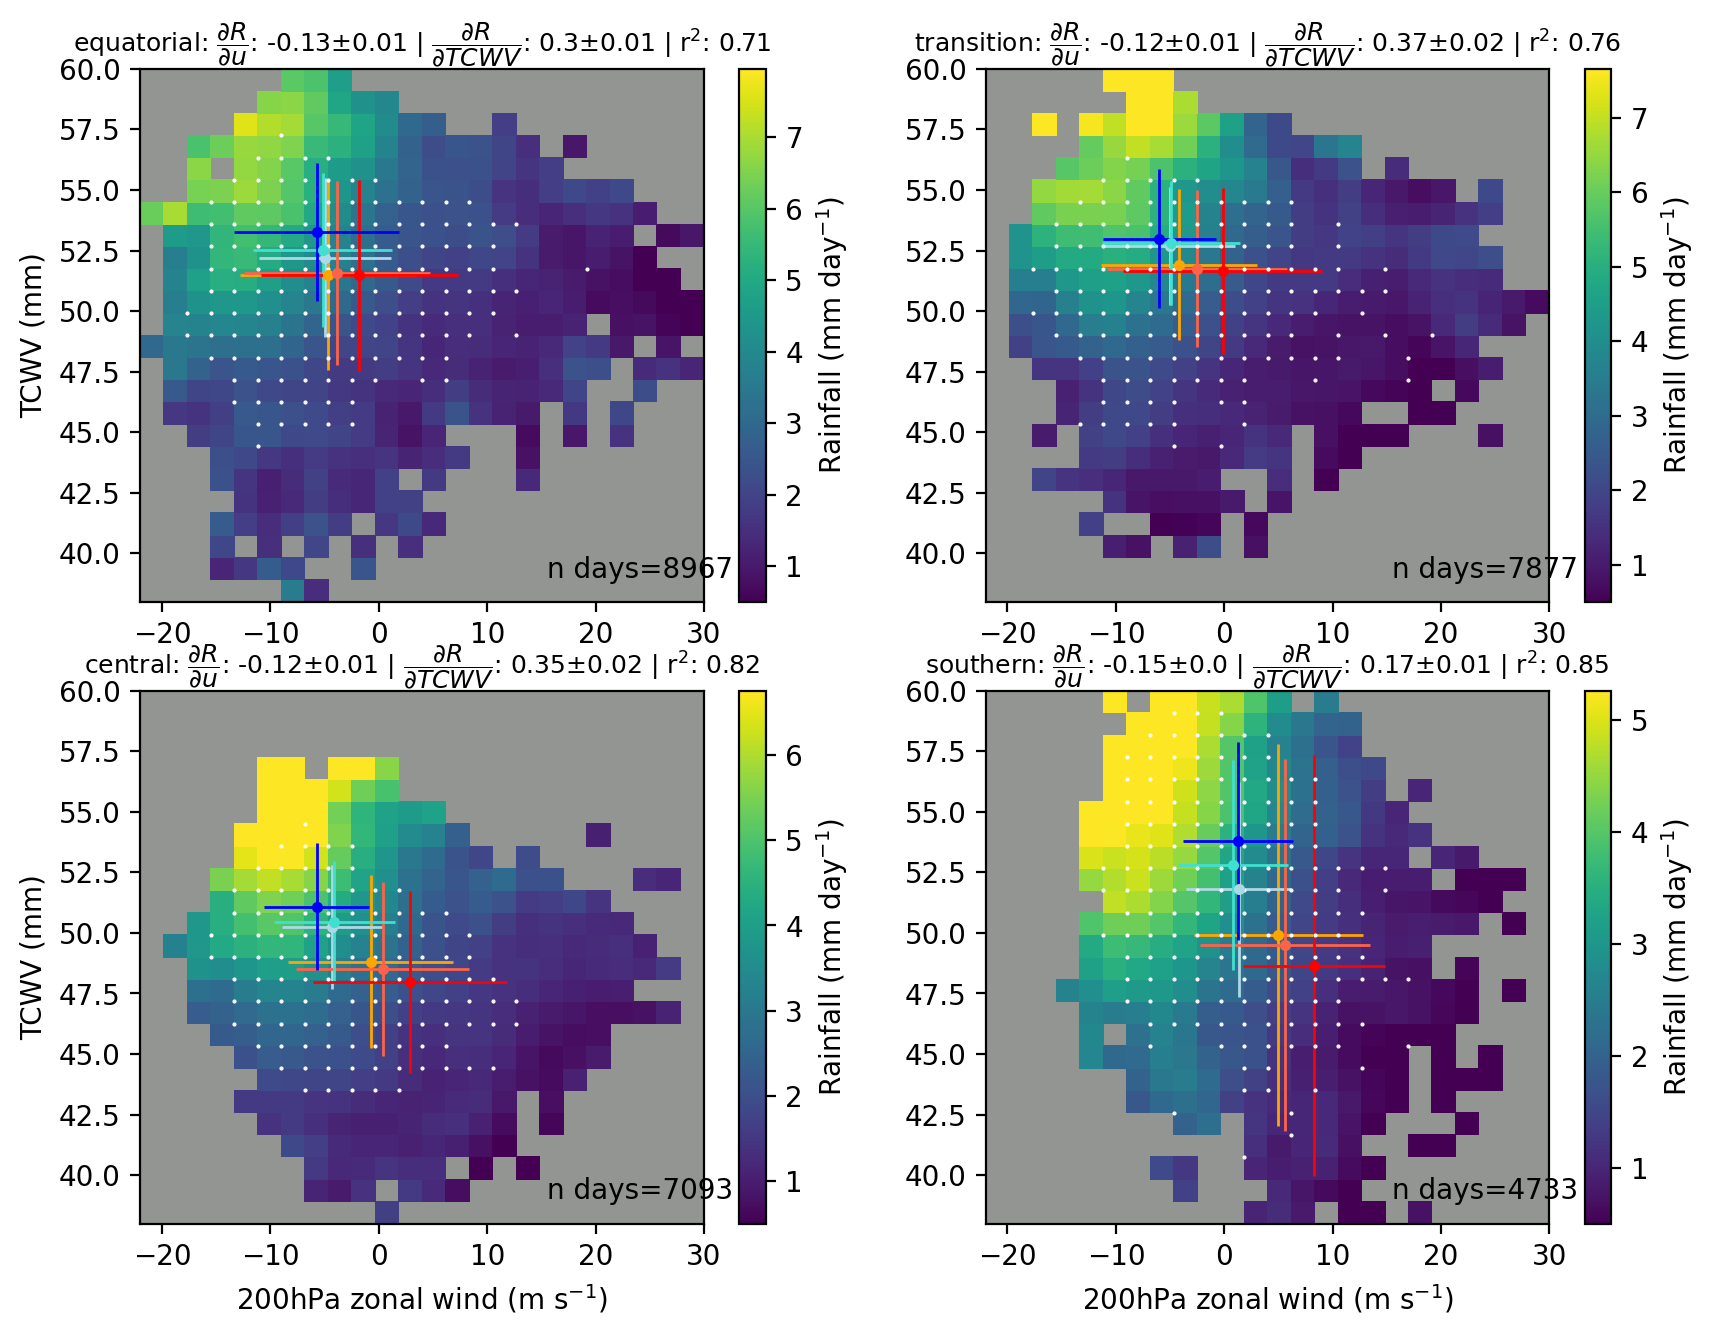

In [165]:
slopes2d = {}  #u, then TCW
# Create 4x4 Grid

f = plt.figure(figsize=(10,10), dpi=200)
gs = f.add_gridspec(nrows=3, ncols=2, height_ratios=[2,2,1])

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>1500))

    erav_region = v850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<1500))
    eraq_region = q850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<1500))
    tcwv_region = Tca.where((topo_on_g<1500)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    
    
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>1500))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
    xxv8 = erav_region.mean(['latitude', 'longitude'])#.groupby(erav_region['time.year']).mean()
    xxq8 = eraq_region.mean(['latitude', 'longitude'])#.groupby(eraq_region['time.year']).mean()
    xxtc = tcwv_region.mean(['latitude', 'longitude'])
  #  ipdb.set_trace()

    #ax = f.add_subplot(2,2,ids+1)
    if ids in [0,1]:
        ax = f.add_subplot(gs[0,ids])
    else:
        ax = f.add_subplot(gs[1,ids-2])
    
    q1 = 0.1
    q2 = 99.9
    sbin = np.linspace(np.percentile(xxu2,q1) ,np.percentile(xxu2,q2),19)
    #tbin = np.linspace(np.percentile(xxq8,q1) ,np.percentile(xxq8,q2),19)
    tbin = np.linspace(np.percentile(xxtc,q1) ,np.percentile(xxtc,q2),19)
    
    tbin = np.linspace(38,60,25)
    sbin = np.linspace(-22,30,25)
    
    p1,p2 = np.percentile(xxch,[10,89])

    testbins = [sbin,tbin]
    func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
    func2 = lambda y: np.sum(np.isfinite(y))
    func3 = lambda y: np.sum(y>1)
    ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
    count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
    thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)
    
    dicobs = run_small_2d(ret, count, testbins)
    
    ax.set_facecolor('xkcd:grey')
    
    cctar=count.statistic.T
    target = np.sum(count.statistic.T)*0.8 # get threshold with 80% of cases 
    
    for cc in np.unique(cctar)[::-1]:
        
        breaker = np.sum(cctar[cctar>=cc])
        if breaker >= target:
            tests = cc
            break
    
    maskpos = np.where(count.statistic.T>=tests)
    dd = gauss(ret.statistic.T, 0.8) #count.statistic.T #gauss(ret.statistic.T, 0.8)
    pixelval=3
    invalid = count.statistic.T < pixelval
    dd[invalid] = np.nan
#     bigpos = np.where(dd>60)
#     print('bigpos', bigpos)
    mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis',vmax=p2-1, vmin=0.5) #vmax=p2-1, vmin=0.5
    plt.plot(testbins[0][maskpos[1]],testbins[1][maskpos[0]],'.', color='white', markersize=1)
    

    
    wcolors = ['lightblue', 'turquoise', 'blue']
    dcolors = ['orange', 'tomato', 'red']
    for sid, snb in enumerate(['3', '5', '7']):
        dreg = drymeans[snb][ids]
        wreg = wetmeans[snb][ids]
        dregstd = drystd[snb][ids]
        wregstd = wetstd[snb][ids]
        plt.errorbar(dreg[1]+1, dreg[2]+1, yerr=dregstd[2], xerr=dregstd[1], color=dcolors[sid], marker='o', elinewidth=1, ms=3)
        plt.errorbar(wreg[1]+1, wreg[2]+1, yerr=wregstd[2], xerr=wregstd[1], color=wcolors[sid], marker='o', elinewidth=1, ms=3)

    plt.colorbar(mp, label='Rainfall (mm day$^{-1}$)')
    if ids in [2,3]:
        plt.xlabel( r'200hPa zonal wind (m s$^{-1}$)')  #'200hPa zonal wind (m s$^{-1}$)'
    if ids in [0,2]:
        plt.ylabel('TCWV (mm)')
    
#     if r == 'southern':
#         dicobs['slope_y']= 0.3674
        
    plt.title( r+r': $\dfrac{\partial R}{\partial u}$: '+ str(np.round(dicobs['slope_x'],2)) + r'$\pm$'+str(np.round(dicobs['model'].bse[1],2))+ \
              r' | $\dfrac{\partial R}{\partial TCWV}$: '+ str(np.round(dicobs['slope_y'],2))+ r'$\pm$'+str(np.round(dicobs['model'].bse[2],2))+ r' | r$^{2}$: '+str(np.round(dicobs['model'].rsquared,2)), fontsize=9)
    
    plt.xlim(testbins[0][0],testbins[0][-1])
    plt.ylim(testbins[1][0],testbins[1][-1])
   
    #ipdb.set_trace()
    
    
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    #plt.text(15,34.5,'n days='+str(math.trunc(np.sum(count.statistic))))
    plt.text(x_max-14.5,y_min+1,'n days='+str(math.trunc(np.sum(count.statistic))))
    #ipdb.set_trace()
    
    
    slopes2d[r] = (dicobs['slope_x'],dicobs['slope_y'],dicobs['intercept'], dicobs['model'].bse[1], dicobs['model'].bse[2]) 

    
################################# bottom plot    
    
ax1 = f.add_subplot(gs2[2,:])
shi = [-0.1,0,0.1,0.2]
step = [0, 0.25, 0.5]

for ids, r in enumerate(regions.keys()):
    for dnid, dnb in enumerate(['3','5', '7']):

#         dreg = drymeans[dnb][ids]
#         wreg = wetmeans[dnb][ids]
#         dregstd = drystd[dnb][ids]
#         wregstd = wetstd[dnb][ids]

        u2stats  = tstats[dnb][ids][0]
        tcstats = tstats[dnb][ids][1]

        statsi = slopes2d[r]
        slopeu = statsi[0]
        slopet = statsi[1]
        inter = statsi[2]

        erru = statsi[3]
        errt = statsi[4]
        #ipdb.set_trace()
        um = u2stats["Difference in mean"] *slopeu
        tm = tcstats["Difference in mean"] *slopet
        
        erru = np.vstack(((abs(u2stats["Difference in mean"])-abs(u2stats["lb"]))*slopeu,  (abs(u2stats["ub"])-abs(u2stats["Difference in mean"]))*slopeu))
        errt = np.vstack(((abs(tcstats["Difference in mean"])-abs(tcstats["lb"]))*slopet,  (abs(tcstats["ub"])-abs(tcstats["Difference in mean"]))*slopet))
        #ipdb.set_trace()
        upval = u2stats["pvalue 2 sided"].values
        tpval = tcstats["pvalue 2 sided"].values
        
        mdiff = um-tm
        #ipdb.set_trace()
        errdiff = np.max(np.array([erru[0]-errt[1], errt[0]-erru[1]]))/2
        #ub = u2stats["ub"]*slopeu - tcstats["ub"]*slopet)
        
        #errs = np.vstack((lb,ub))
        
        if upval <=0.05:
            uecol = 'k'
        else:
            uecol = 'grey'
        if tpval <=0.05:
            tecol = 'k'
        else:
            tecol = 'grey'

        #ipdb.set_trace()
#         bar1 = ax1.bar(ids+shi[0]+step[dnid], um, color='r', width=0.1, yerr=erru, linewidth=0.5, ecolor=uecol)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], tm, color='lightblue', width=0.1, yerr=errt, ecolor=tecol)



#         bar1 = ax1.bar(ids+shi[0]+step[dnid], (wreg[1]-dreg[1])*slopeu, color='r', width=0.1, yerr=((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu), linewidth=0.5)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], (wreg[2]-dreg[2])*slopet, color='lightblue', width=0.1, yerr=((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet))

#         ub = (wreg[1]-dreg[1])*slopeu
#         tb = (wreg[2]-dreg[2])*slopet
#         udiff = ((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu)
#         tdiff = ((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet)

#         if mdiff < 0:
#             col = 'lightblue'
#         else:
#             col = 'grey'
        bar2 = ax1.bar(ids+shi[0]+step[dnid], mdiff, color=colord[dnid], width=0.25, yerr=errdiff)
        ax1.axhline(0, linestyle='dashed', color='k', linewidth=0.5)

    
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/tcw_u200_2dhist_origSpells.jpg')

In [64]:
pdu

T statistic          df  pvalue 2 sided  Difference in mean        lb  \
0    -6.598463  112.111148    1.430206e-09            -7.40415 -9.627427   

         ub  
0 -5.180872

In [70]:
tstats['3'][0]

(   T statistic          df  pvalue 2 sided  Difference in mean        lb  \
 0    -0.369055  937.699884         0.71217            -0.17375 -1.097691   
 
          ub  
 0  0.750191  ,
    T statistic          df  pvalue 2 sided  Difference in mean       lb  \
 0     3.266153  913.156938        0.001131            0.746067  0.29777   
 
          ub  
 0  1.194364  )

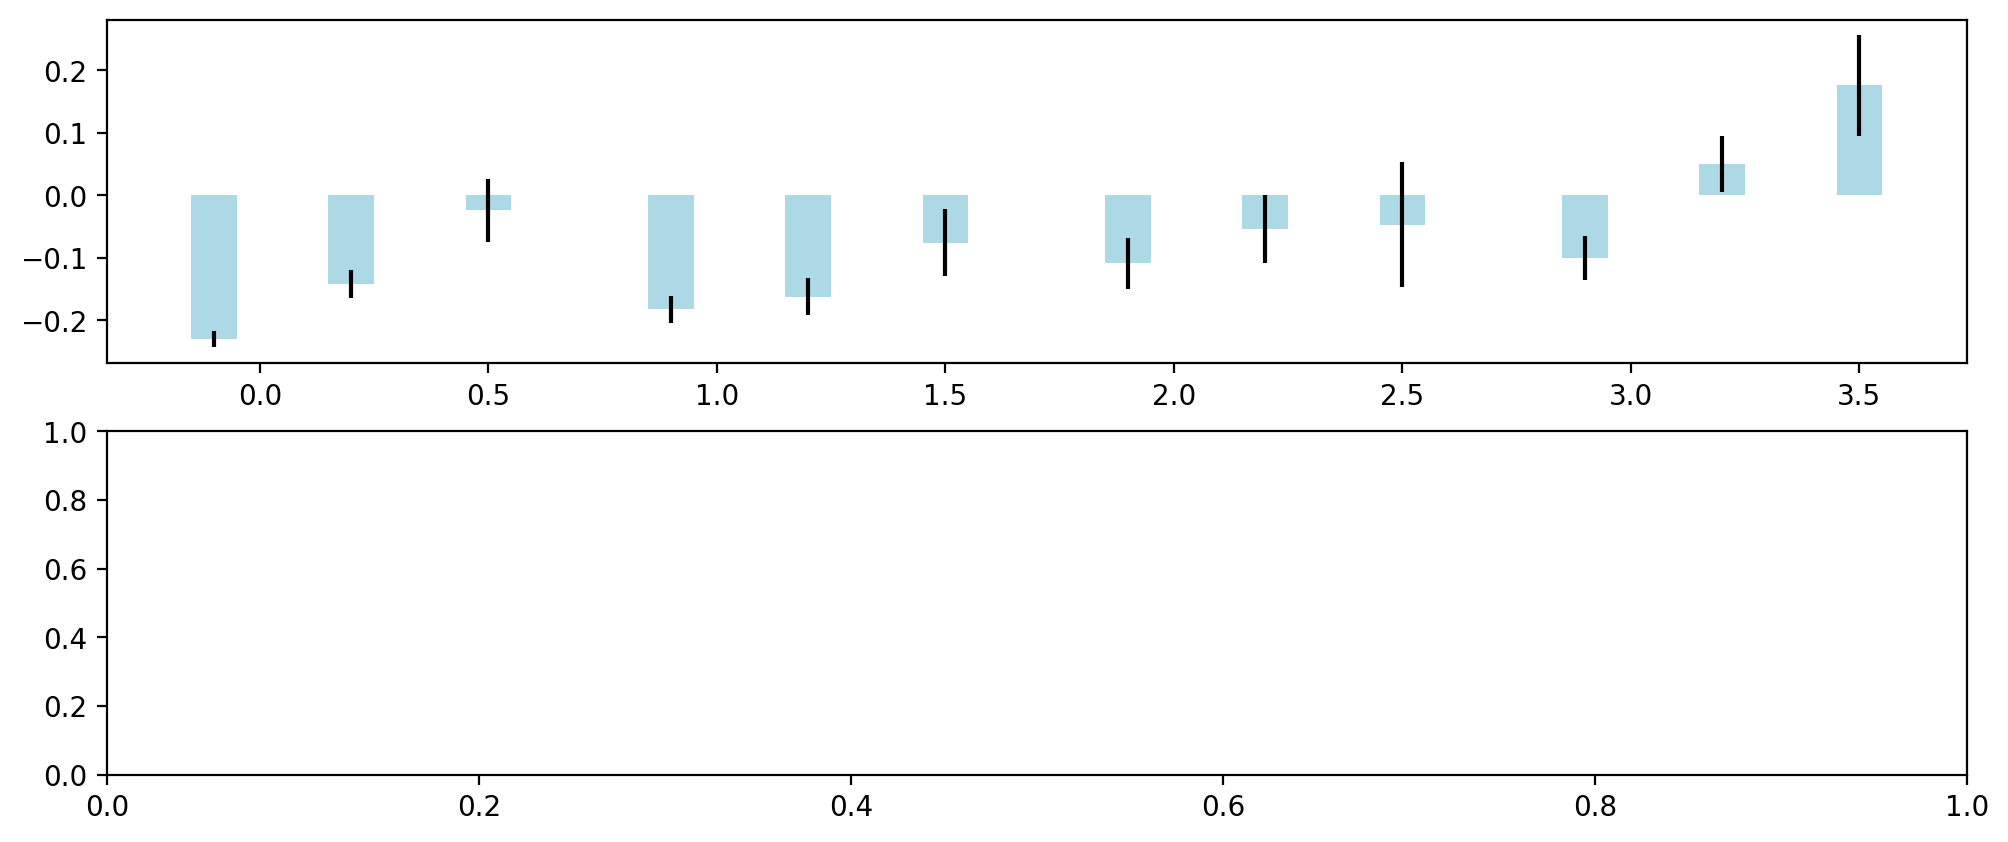

In [92]:
f = plt.figure(figsize=(12,5), dpi=200)

ax = f.add_subplot(211)
ax1 = f.add_subplot(212)

shi = [-0.1,0,0.1,0.2]

step = [0, 0.3, 0.6]

for ids, r in enumerate(regions.keys()):
    for dnid, dnb in enumerate(['3','5', '7']):

        dreg = drymeans[dnb][ids]
        wreg = wetmeans[dnb][ids]
        dregstd = drystd[dnb][ids]
        wregstd = wetstd[dnb][ids]

    #     print(r, 'mm / ms',(wetmeans['7'][ids][0] - drymeans['7'][ids][0]) / (wetmeans['7'][ids][1] - drymeans['7'][ids][1]))
    #     print(r, 'mm/ mm',(wetmeans['7'][ids][0] - drymeans['7'][ids][0]) / (wetmeans['7'][ids][2] - drymeans['7'][ids][2]))

        statsi = slopes2d[r]
        slopeu = statsi[0]
        slopet = statsi[1]
        inter = statsi[2]

        erru = statsi[3]
        errt = statsi[4]
        
#         bar1 = ax.bar(ids+shi[0]+step[dnid], (wreg[1]-dreg[1])*-1, color='r', width=0.1, yerr=((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu), linewidth=0.5)
#         bar2 = ax.bar(ids+shi[1]+step[dnid], (wreg[2]-dreg[2]), color='lightblue', width=0.1, yerr=((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet))


#         bar1 = ax1.bar(ids+shi[0]+step[dnid], (wreg[1]-dreg[1])*slopeu, color='r', width=0.1, yerr=((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu), linewidth=0.5)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], (wreg[2]-dreg[2])*slopet, color='lightblue', width=0.1, yerr=((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet))

        ub = (wreg[1]-dreg[1])*slopeu
        tb = (wreg[2]-dreg[2])*slopet
        udiff = ((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu)
        tdiff = ((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet)
        
        bar2 = ax.bar(ids+shi[0]+step[dnid], ub-tb, color='lightblue', width=0.1, yerr=udiff-tdiff)

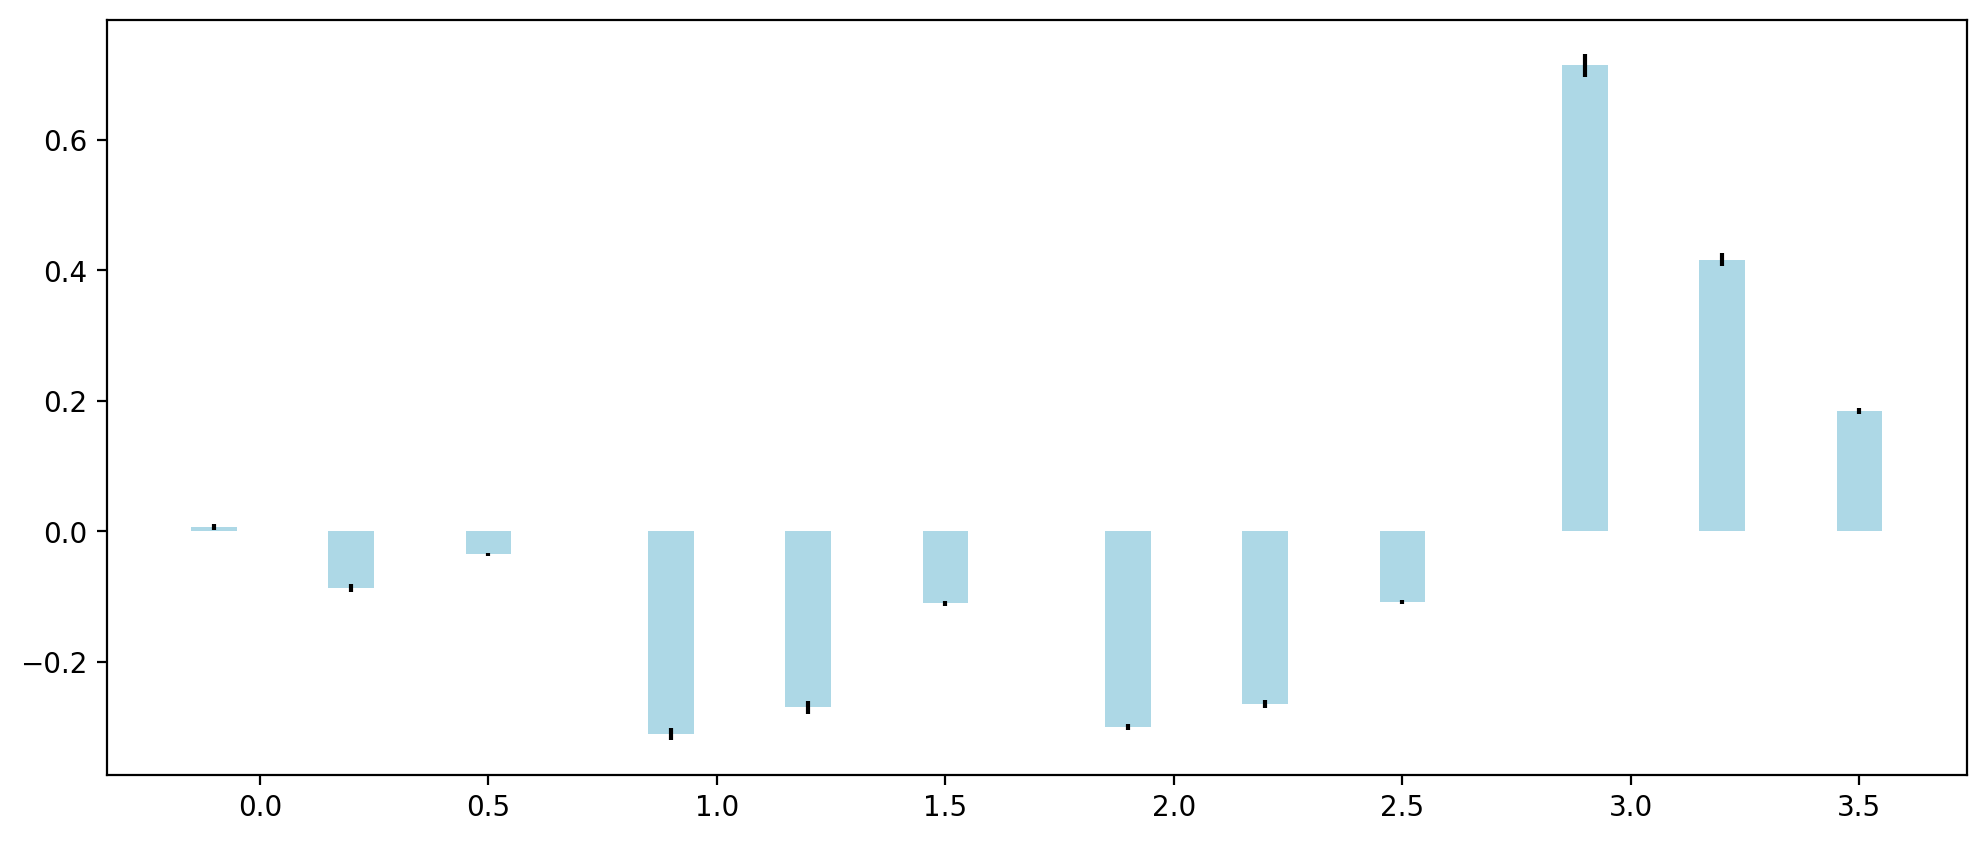

In [62]:
f = plt.figure(figsize=(12,5), dpi=200)

ax = f.add_subplot(111)

shi = [-0.1,0,0.1,0.2]

step = [0, 0.3, 0.6]

for ids, r in enumerate(regions.keys()):
    for dnid, dnb in enumerate(['d','m', 'y']):

        dreg = climstd[dnb][ids]
        
       # ipdb.set_trace()

    #     print(r, 'mm / ms',(wetmeans['7'][ids][0] - drymeans['7'][ids][0]) / (wetmeans['7'][ids][1] - drymeans['7'][ids][1]))
    #     print(r, 'mm/ mm',(wetmeans['7'][ids][0] - drymeans['7'][ids][0]) / (wetmeans['7'][ids][2] - drymeans['7'][ids][2]))

        statsi = slopes2d[r]
        slopeu = statsi[0]
        slopet = statsi[1]
        inter = statsi[2]

        erru = statsi[3]
        errt = statsi[4]


#         bar1 = ax.bar(ids+shi[0]+step[dnid], (dreg[1])*slopeu*-1, color='r', width=0.1, yerr=((dreg[1])*(slopeu+erru)) - ((dreg[1])*slopeu), linewidth=0.5)
#         bar2 = ax.bar(ids+shi[1]+step[dnid], (dreg[2])*slopet, color='lightblue', width=0.1, yerr=((dreg[2])*(slopet+errt)) - ((dreg[2])*slopet))

        ub = (dreg[1])*slopeu*-1
        tb = (dreg[2])*slopet
        udiff = ((dreg[1])*(slopeu+erru)) - ((dreg[1])*slopeu)
        tdiff = ((dreg[2])*(slopet+errt)) - ((dreg[2])*slopet)
        
        bar2 = ax.bar(ids+shi[0]+step[dnid], ub-tb, color='lightblue', width=0.1, yerr=udiff-tdiff)

In [ ]:
bardir = {}
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    era_region = u200ca['u'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e)))
    tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    chirps_region = cau200.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e)))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()

    xxtcw = tcwv_region.mean(['latitude', 'longitude'])#.groupby(tcwv_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    
    bardir[r] = [xxch, xxu2, xxtcw]

In [ ]:
from endgame import hist2d


barlist = []
errlist = []
yearlist = []
slopeerr = []
rlist = []
plist = []

nyears = len(allyears) #10

for ids, r in enumerate(regions.keys()):
    
    #scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values]
    
   # ax = f.add_subplot(2,2,ids+1)

    statsi = slopes2d[r]
    slopeu = statsi[0]
    slopet = statsi[1]
    inter = statsi[2]
    
    
    xxch = bardir[r][0]
    xxu2 = bardir[r][1]
    xxtc = bardir[r][2]
    
    ych = xxch.groupby('time.year').mean('time')
    yu2 = xxu2.groupby('time.year').mean('time')
    ytc = xxtc.groupby('time.year').mean('time')
    
    #daybasis
    
    chstd = np.std(xxch)
    u2std = np.std(xxu2) * slopeu
    tcstd = np.std(xxtc) * slopet
    bothstd = u2std + tcstd
    
    #ybasis
    if r == 'southern':
        slopet = (slopes2d['central'])[1]
    
    ychstd = np.std(ych)
    yu2std = np.std(yu2) * slopeu
    ytcstd = np.std(ytc) * slopet
    bothstd = yu2std + ytcstd
    
    #trends

    stc, interceptc, rrc, pc, sec = linregress(allyears, ych)
    stu, interceptu, rru, pu, seu  = linregress(allyears, yu2)
    stt, interceptt, rrt, pt, sett  = linregress(allyears, ytc)
    
    trendc = stc*nyears
    trendu = stu*nyears * slopeu
    trendt = stt*nyears * slopet
    
    
    barlist.append( (trendc, trendu, trendt))
    errlist.append( (chstd, u2std,tcstd))
    yearlist.append( (ychstd, yu2std,ytcstd))
    slopeerr.append( (sec*nyears, seu*nyears*slopeu,sett*nyears*slopet))
    rlist.append((rrc, rru, rrt))
    plist.append((pc, pu, pt))

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.314
Model:                            WLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     145.4
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           7.91e-28
Time:                        13:35:34   Log-Likelihood:                -608.39
No. Observations:                 320   AIC:                             1221.
Df Residuals:                     318   BIC:                             1228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.8683      1.151     -8.573      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:764: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))
/home/ck/miniconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:764: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.399
Model:                            WLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     210.7
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           5.51e-37
Time:                        13:35:54   Log-Likelihood:                   -inf
No. Observations:                 320   AIC:                               inf
Df Residuals:                     318   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1435      0.555     -9.264      0.0

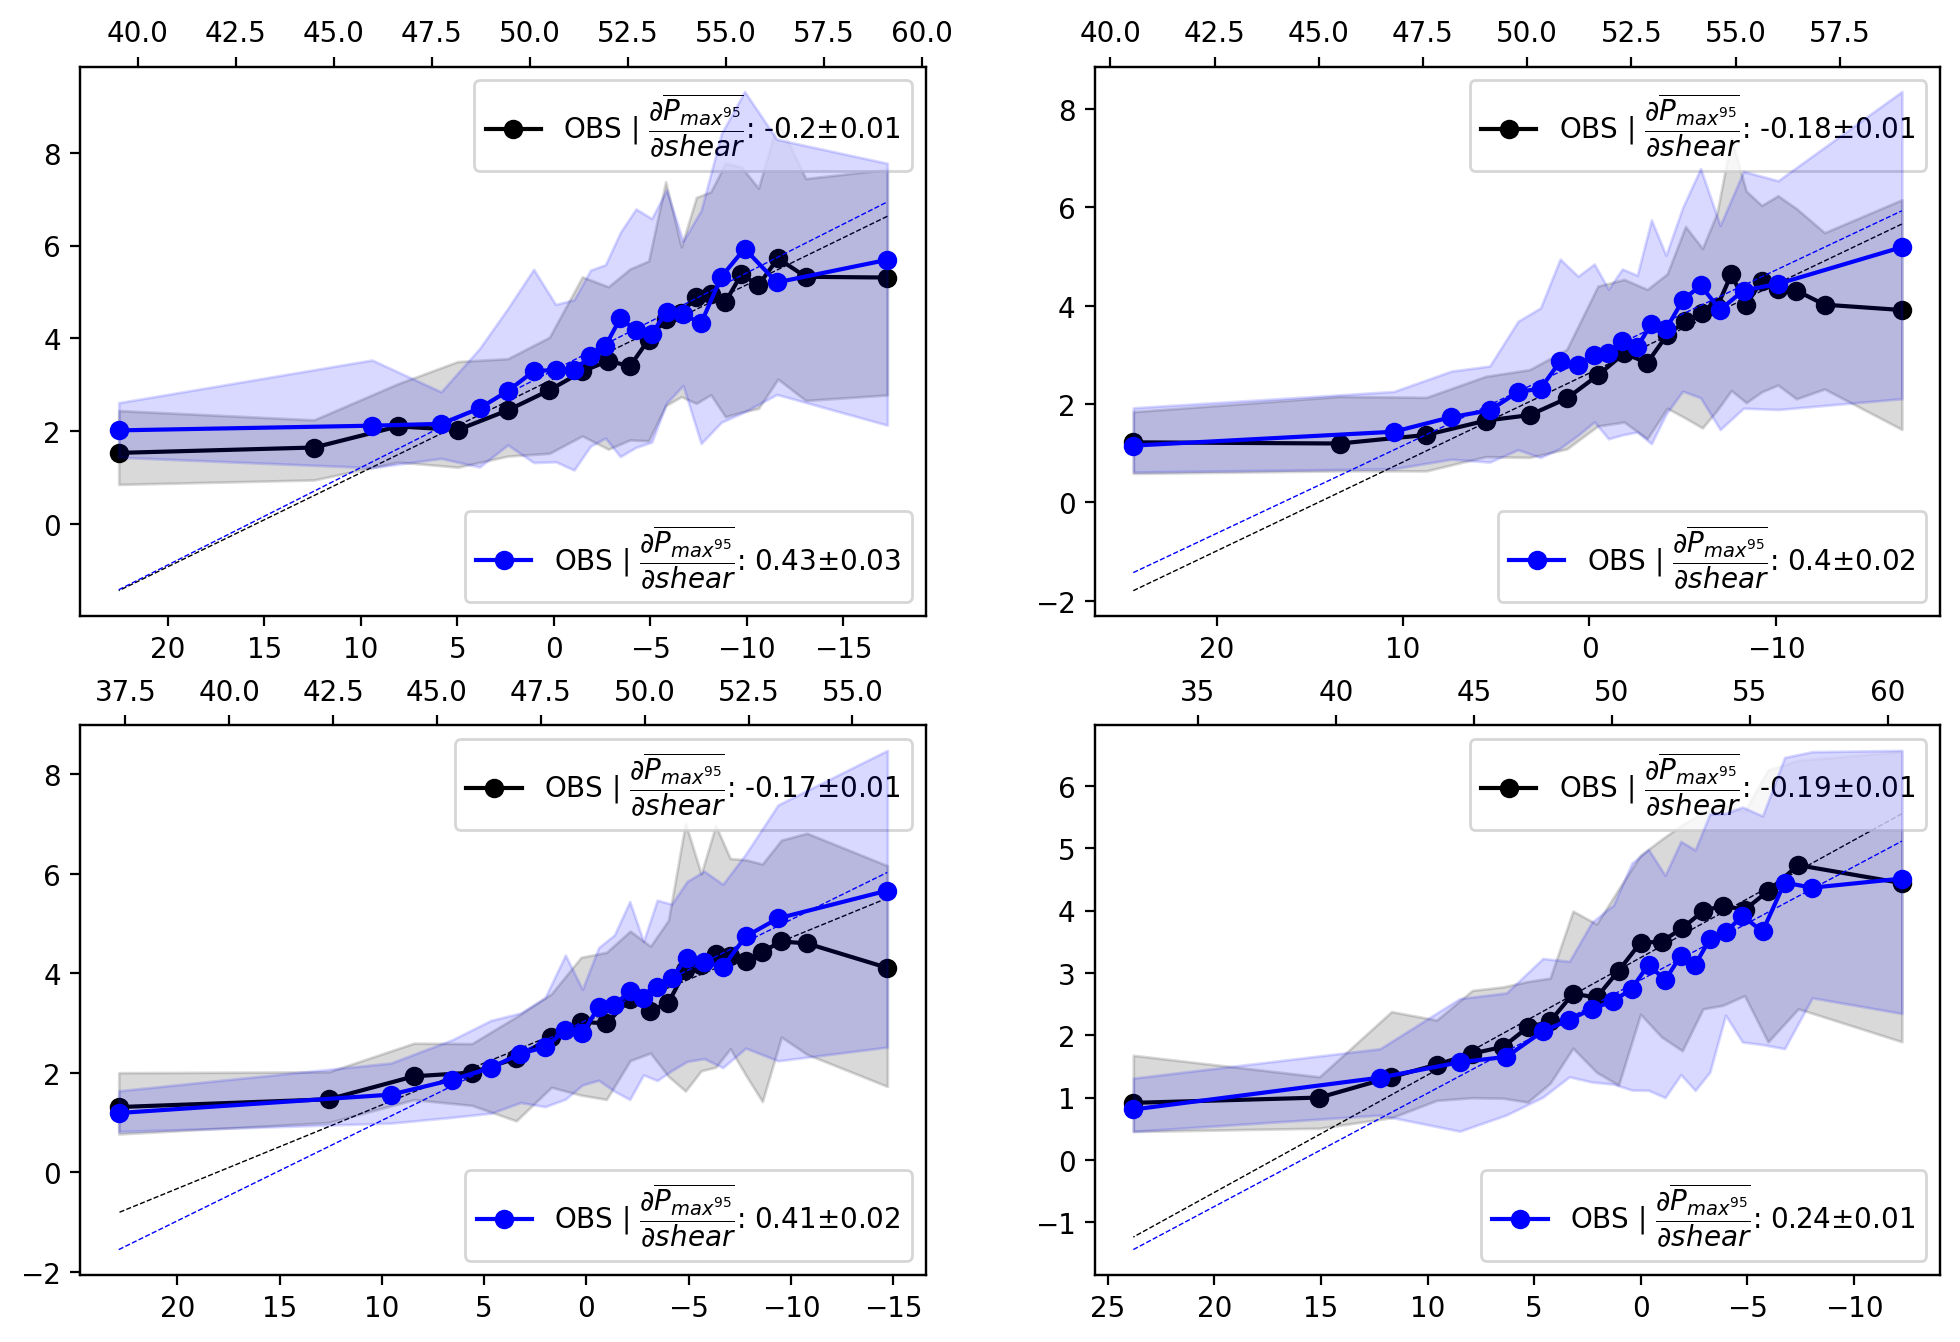

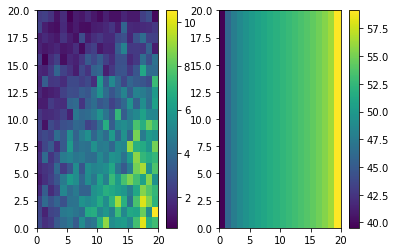

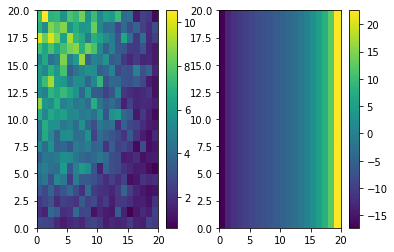

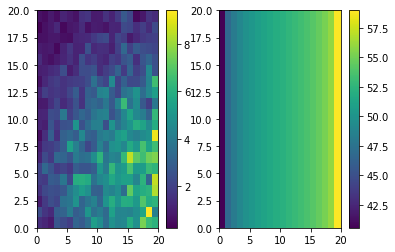

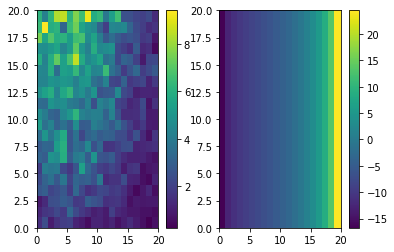

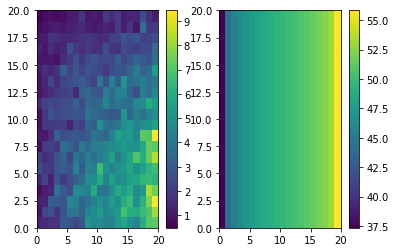

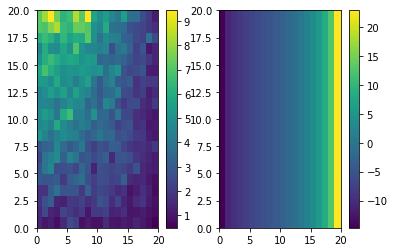

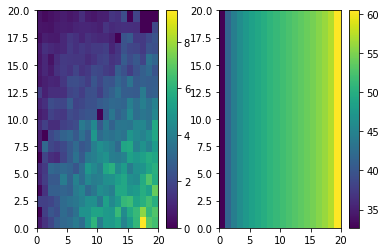

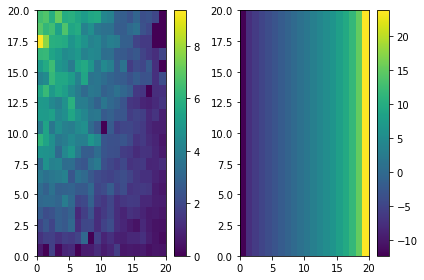

In [107]:
f = plt.figure(figsize=(12,8), dpi=200)
regqbins = []
regubins = []
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))

    erav_region = v850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<h))
    eraq_region = q850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<h))*1000
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))
    tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
    xxv8 = erav_region.mean(['latitude', 'longitude'])#.groupby(erav_region['time.year']).mean()
    xxq8 = eraq_region.mean(['latitude', 'longitude'])#.groupby(eraq_region['time.year']).mean()
    xxtc = tcwv_region.mean(['latitude', 'longitude'])
    
    ax = f.add_subplot(2,2,ids+1)
    ax1 = ax.twiny()
    ax.invert_xaxis()

    sbin = np.percentile(xxu2, [0.1]+list(np.arange(5,96,5))+[99.9])
    tbin = np.percentile(xxtc, [0.1]+list(np.arange(5,96,5))+[99.9])
    
#     q1 = 0.1
#     q2 = 99.9
#     sbin = np.linspace(np.percentile(xxu2,q1) ,np.percentile(xxu2,q2),17)
#     tbin = np.linspace(np.percentile(xxq8,q1) ,np.percentile(xxq8,q2),17)
    
    #p1,p2 = np.percentile(xxch,[10,89])
    
    testbins = [sbin,tbin]
    func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
    func2 = lambda y: np.sum(np.isfinite(y))
    func3 = lambda y: np.sum(y>1)
    
    ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
    count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
    thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)
    
    tdicobs = run_small(ret, count, testbins,axis=1)
    sdicobs = run_small(ret, count, testbins,axis=0)
    
    tdicobs_nomean = run_small_nomean(ret, count, testbins,axis=1) #tcw
    sdicobs_nomean = run_small_nomean(ret, count, testbins,axis=0) #u200
    
    #dicobs = run_small_2d(ret, count, testbins)


    ax.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
    ax.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
    ax.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    #ax.plot(dicobs['bins_x'], dicobs['slope']*dicobs['bins_x']+dicobs['intercept'], linestyle='dashed', color='r', linewidth=0.5)
    
    ax1.plot(tdicobs['bins'],tdicobs['pmean'], '-bo', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(tdicobs['slope'],2))+'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
    ax1.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='b', alpha=0.15)
    ax1.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='b', linewidth=0.5)
    ax.legend(loc='upper right')
    ax1.legend(loc='lower right')
   # plt.title('both var:'+str(np.round(dicobs['rval'],2))+', slope_x,y:'+str(np.round(dicobs['slope_x'],2))+'_'+str(np.round(dicobs['slope_y'],2)))
    
    regqbins.append((tbin[1], tbin[-2]))
    regubins.append( (sbin[1], sbin[-2]))
    
plt.tight_layout()


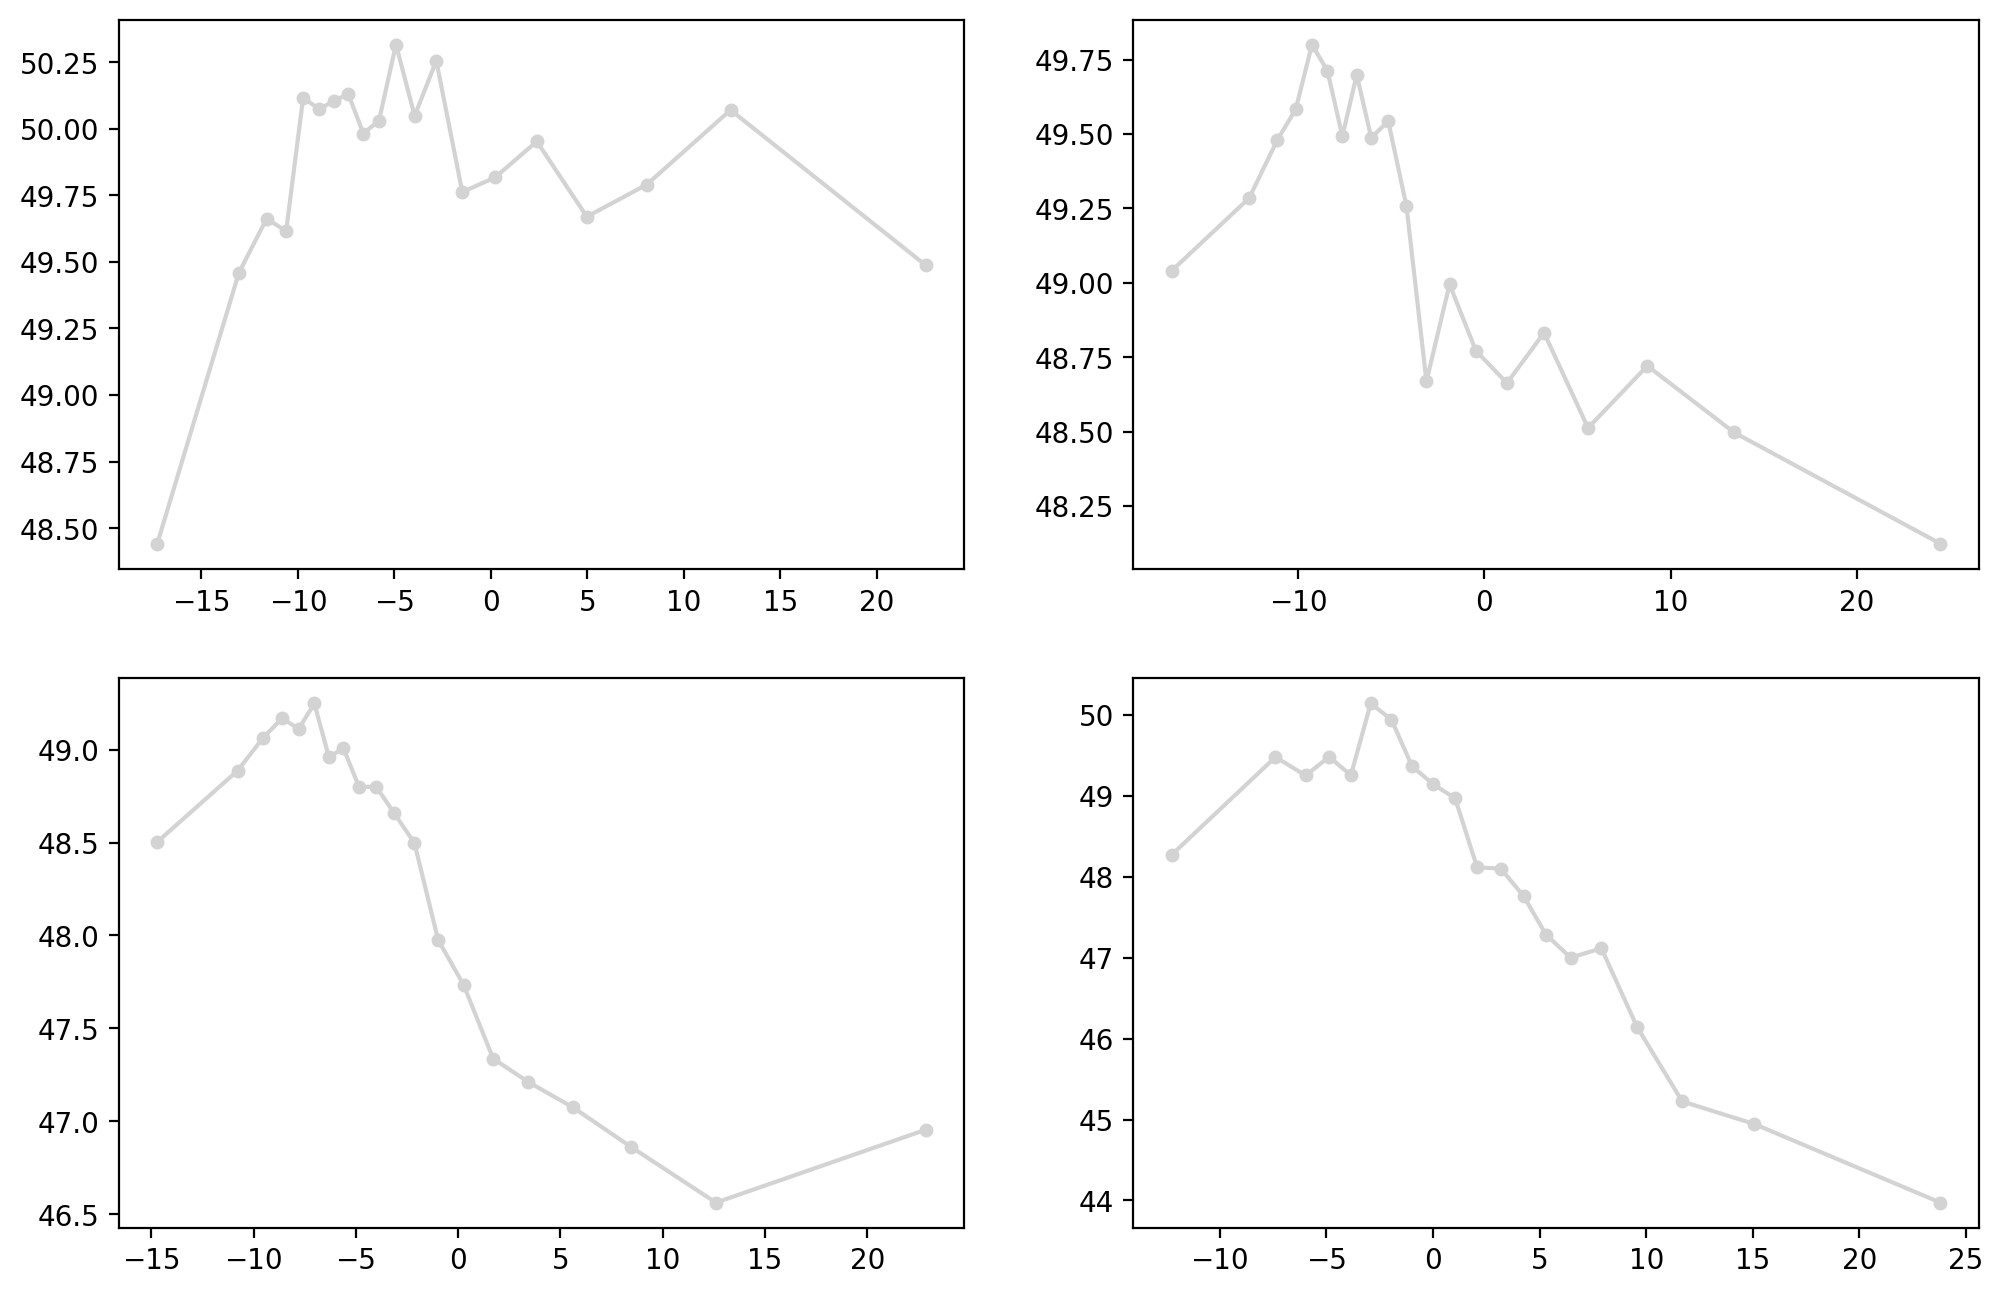

In [33]:
f = plt.figure(figsize=(12,8), dpi=200)

for ids, r in enumerate(regions.keys()):
    
    ax = f.add_subplot(2,2,ids+1)
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))
    tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
    xxtc = tcwv_region.mean(['latitude', 'longitude'])
    
    sbin = np.percentile(xxu2, [0.1]+list(np.arange(5,96,5))+[99.9])
    dic = hist2d.var2_binning_mean(xxu2,xxtc,sbin)
    ax.plot(dic['xbins'], dic['y'], marker='o', markersize=4, color='lightgrey')

In [117]:
def run_small_nomean(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 3
    dd[invalid] = np.nan
    
    val = np.isfinite(dd).astype(int)
    
    #perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    bins = np.array(list(bins)*dd.shape[0]).reshape(dd.shape)
    fillmean = dd.copy()
    fillmean[np.isnan(fillmean)]=0
    
    if axis == 1:
        fillmean = fillmean.T 

    val[np.isnan(fillmean)]=0
    
    f = plt.figure()
    ax = f.add_subplot(121)
    plt.pcolormesh(fillmean)
    plt.colorbar()
    ax = f.add_subplot(122)
    plt.pcolormesh(bins)
    plt.colorbar()
    
    
   # ipdb.set_trace()
    wls_model = weighted_regress(bins[2:-2].flatten(), fillmean[2:-2].flatten(), val[2:-2].flatten())

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    #ipdb.set_trace()
    
    print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
#         'p90' : perc[0],
#         'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [118]:
def run_small(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 3
    dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    mean[val<10] = np.nan
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    wls_model = weighted_regress(bins[2:-2], fillmean[2:-2], val[2:-2])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    #ipdb.set_trace()
    
    #print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [74]:
def run_small_2d(data, count, testbins):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 3
    dd[invalid] = np.nan
    
    
    mean_x = np.nanmean(dd,axis=0)
    val_x = np.nansum(np.isfinite(dd),axis=0)
    mean_x[val_x<4] = np.nan
    perc_x = np.nanpercentile(dd, [10,90], axis=0)
    
    mean_y = np.nanmean(dd,axis=1)
    val_y = np.nansum(np.isfinite(dd),axis=1)
    mean_y[val_y<4] = np.nan
    perc_y = np.nanpercentile(dd, [10,90], axis=1)
    
    
    sbin = testbins[0]
    tbin = testbins[1]
    ssbins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    ttbins = np.round(tbin[0:-1]+((tbin[1::]-tbin[0:-1])/2),2)
    
    X,Y = np.meshgrid(ssbins, ttbins)

    # First we need to flatten the data: it's 2D layout is not relevent.
    counts = count.statistic.T
    Z = dd.flatten()
    X = X.flatten()
    Y = Y.flatten()
    inval = counts.flatten()
    
   
    ################################################################
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

    # Print the summary
    print(model.summary())

    #print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('\nANOVA results')
    print(anova_results)

    #plt.show()
    ################################################################
   # ipdb.set_trace()
    intercept = model.params[0] #  intercept
    slope_x = model.params[1] #  slope
    slope_y = model.params[2]
    r_value = model.rsquared  #rsquared

    
    odic = {
        'model' : model,
        'pmean_x' :mean_x,
        'pmean_y' :mean_y,
        'p90_x' : perc_x[0],
        'p10_x' : perc_x[1],
        'p90_y' : perc_y[0],
        'p10_y' : perc_y[1],
        'bins_x' : ssbins,
        'bins_y' : ttbins,
        'slope_x' : slope_x,
        'slope_y' : slope_y,
        'intercept' : intercept,
        'rval' : r_value,
    }
    
    return odic

KeyError: 'q'

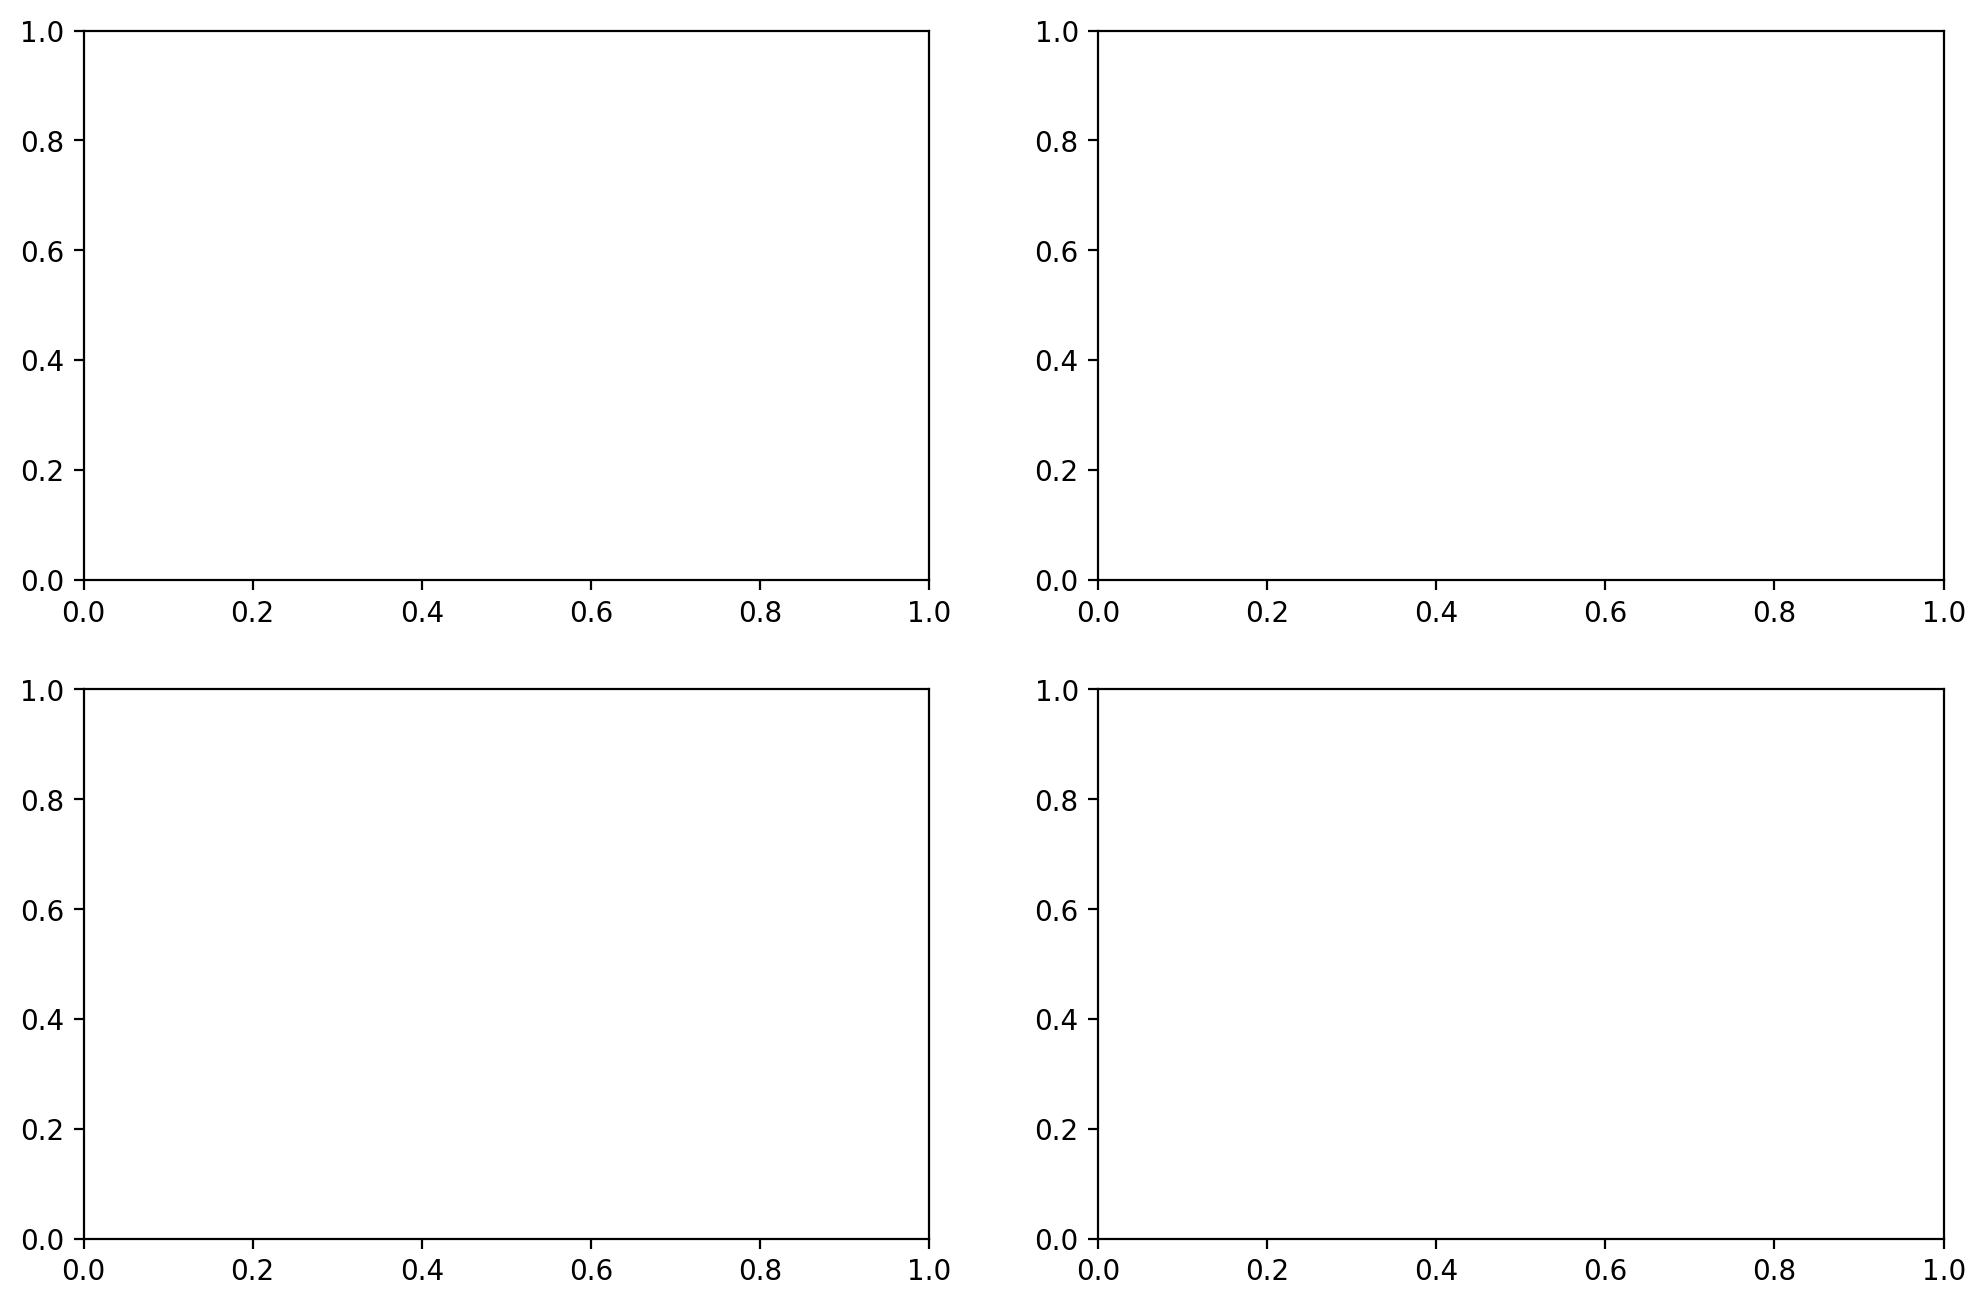

In [101]:
f = plt.figure(figsize=(12,8), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>h)).mean(['latitude', 'longitude'])
    erav_region = v850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).mean(['latitude', 'longitude'])
    eraq_region = q850ca['q'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).mean(['latitude', 'longitude'])*1000
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>h)).mean(['latitude', 'longitude'])
    
    
    era_region_gr = u200gr.sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200gr['time.dayofyear']>=doys_s) | (u200gr['time.dayofyear']<=doys_e))).where((topo_on_g>h)).mean(['latitude', 'longitude'])
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((grid200['time.dayofyear']>=doys_s) | (grid200['time.dayofyear']<=doys_e))).where((topo_on_g>h)).mean(['latitude', 'longitude'])

    mask = np.isfinite(era_region) #& (chirps_region > 0.01) 
    qmask = np.isfinite(eraq_region)
    mask_gr = np.isfinite(era_region_gr) & (grid_region < -15)
    #xbins = np.arange(-18,19,2)
    #ipdb.set_trace()
    xbins = np.percentile(era_region.values[mask], [0.1]+list(np.arange(5,96,5))+[99.9])
    qbins = np.percentile(eraq_region.values[qmask], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])
    
    dic = hist2d.var2_binning_mean(era_region.values[mask],chirps_region.values[mask],xbins)
    dicq = hist2d.var2_binning_mean(eraq_region.values[qmask],chirps_region.values[qmask],qbins)

    stx = 2
    ste = -2
    intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
    
    #ipdb.set_trace()
    interceptq, slopeq, r_valueq,rpearsonq, ppearsonq = weighted_regress(dicq['xbins'][stx:ste],dicq['y'][stx:ste],dicq['ycount'][stx:ste] )
    
    print('era u stats', intercept, slope, r_value,rpearson, ppearson )
    print('era q stats', interceptq, slopeq, r_valueq,rpearsonq, ppearsonq )
     
    ts_reconstruct = era_region.copy(deep=True)
    q_reconstruct = eraq_region.copy(deep=True)
    ts_reconstruct.values = slope*(ts_reconstruct.values)+intercept
    #q_reconstruct.values = slopeq*(q_reconstruct.values)+interceptq
    
    q_reconstruct.values = -5.227576747746571 + 0.6957001222034588*(q_reconstruct.values)
    
    xxch = chirps_region.groupby(chirps_region['time.year']).mean().load()#.rolling(year=3, min_periods=2, center=True).mean()
    xxera = ts_reconstruct.groupby(ts_reconstruct['time.year']).mean().load()#.rolling(year=3, min_periods=2, center=True).mean()
    xxq = q_reconstruct.groupby(q_reconstruct['time.year']).mean().load()
    rawera = era_region.groupby(era_region['time.year']).mean().load()
    rawq =  eraq_region.groupby(eraq_region['time.year']).mean().load()
    #rawera= (rawera.where(rawera<-2).groupby(era_region['time.year']).count()/rawera.groupby(era_region['time.year']).count())*100#.rolling(year=3, min_periods=2, center=True).mean()
    
    isfin = np.isfinite(xxch)&np.isfinite(xxera)
    
    intercept2, slope2, r_value2,rpearson2, ppearson2 = weighted_regress(xxch,rawera)
    
    #print(intercept2, slope2, r_value2,rpearson2, ppearson2)
    
    #ipdb.set_trace()
    
    ax.plot(np.unique(chirps_region['time.year']), rawera-np.mean(rawera), label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], xxera[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    
    #ts_reconstruct = slope*(xxera)+intercept
    isfin = np.isfinite(xxch)&np.isfinite(rawera)
    ax2.plot(np.unique(chirps_region['time.year']), rawera, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], rawera[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    

    ax.set_xlabel('Zonal wind (m s$^{-1}$)')
    ax2.set_xlabel('Zonal wind (m s$^{-1}$)')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Cloud top temperature (K)')
    
    ax3.plot(np.unique(chirps_region['time.year']),rawq-np.mean(rawq), marker='o', markersize=4, color=colord[ids])
    

    ax4.plot(np.unique(chirps_region['time.year']),xxch-np.mean(xxch), marker='o', markersize=4, color=colord[ids])
    
    print('u stddev', np.std(rawera.values)*2, np.std(rawera.values)*2*slope)
    print('q stddev', np.std(rawq.values)*2, np.std(rawq.values)*2*slopeq)
    print('qscaling', slopeq)
    print('uscaling', slope)
    
#     hist, count, h = u_stats.histo_frequency(chirps_region.values[mask], bins=np.arange(0,20,0.1))
#     ax3.plot(np.arange(0,19.9,0.1),hist, label=r, color=colord[ids])
#     ax3.set_yscale('log')
    
ax.legend(fontsize=8)
ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()

In [ ]:
print(udicobs['slope'], udicobs['rval'])
plt.plot(udicobs['bins'],udicobs['pmean'])
plt.plot(udicobs['bins'], udicobs['bins']*udicobs['slope']+udicobs['intercept'], linestyle='dashed')
plt.plot(udicobs['bins'], udicobs['bins']*dicobs['slope_x']+udicobs['intercept'], linestyle='dashed', color='r')

In [ ]:
print(qdicobs['slope'], qdicobs['rval'])
plt.plot(qdicobs['bins'],qdicobs['pmean'])
plt.plot(qdicobs['bins'], qdicobs['bins']*qdicobs['slope']+qdicobs['intercept'], linestyle='dashed')

plt.plot(qdicobs['bins'], qdicobs['bins']*dicobs['slope_y']+qdicobs['intercept'], linestyle='dashed', color='r')

In [ ]:
hist2d_slopes = [udicobs['slope'], qdicobs['slope']]
hist2d_intercepts = [udicobs['intercept'], qdicobs['intercept']]

In [ ]:
hist2d_slopes

In [ ]:
hist2d_intercepts

In [ ]:
hist2d_multislopes = [dicobs['slope_x'], dicobs['slope_y']]

In [ ]:
hist2d_multislopes

In [ ]:
# one-variable regression based on regression of one-sided histogram: this is not seperating the variables but considering correlation per variable individually

from endgame import hist2d
xbins = np.percentile(lq200, [0.1]+list(np.arange(5,96,5))+[99.9])
qbins = np.percentile(lq850, [0.1]+list(np.arange(5,96,5))+[99.9])

masku = np.isfinite(lq200)
maskq = np.isfinite(lq850)

cbins = np.arange(-80,-10,2)#np.percentile(grid_region.values[mask_gr], [0.1]+list(np.arange(5,96,5))+[99.9])

dic = hist2d.var2_binning_mean(lq200,lchir,xbins)
dicq = hist2d.var2_binning_mean(lq850,lchir,qbins)

In [ ]:
stx = 2
ste = -2
intercept, slope, r_value,rpearson, ppearson = weighted_regress(dic['xbins'][stx:ste],dic['y'][stx:ste],dic['ycount'][stx:ste] )
interceptq, slopeq, r_valueq,rpearsonq, ppearsonq = weighted_regress(dicq['xbins'][stx:ste],dicq['y'][stx:ste],dicq['ycount'][stx:ste] )

In [ ]:
print(slope, r_value)
plt.plot(dic['xbins'],dic['y'])
plt.plot(dic['xbins'], dic['xbins']*slope+intercept, linestyle='dashed')

In [ ]:
print(slopeq, r_valueq)
plt.plot(dicq['xbins'],dicq['y'])
plt.plot(dicq['xbins'], dicq['xbins']*slopeq+interceptq, linestyle='dashed')

In [ ]:
hist1d_slopes = [slope, slopeq]
hist1d_intercepts = [intercept, interceptq]

In [ ]:
hist1d_slopes

In [ ]:
hist2d_intercepts

In [106]:
filtdir = {}
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    regu = regubins[ids]
    regq = regqbins[ids]
    
    print(regu, regq)
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>1500))
    tcwv_region = Tca.where((topo_on_g<2000)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>1500))
    grid_region = grid200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>1500))
    
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
    xxgr = grid_region.mean(['latitude', 'longitude'])
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
    xxtc = tcwv_region.mean(['latitude', 'longitude'])
    
    
    regu = np.percentile(xxu2, [0, 95])
    regq = np.percentile(xxtc, [0, 95])
    
    
    print(regu, regq)
    
    mask = (xxu2.values>=regu[0]) & (xxu2.values<=regu[1]) & (xxtc.values>=regq[0]) & (xxtc.values<=regq[1])
    
    #mask = (xxu2.values<=regu[1]) | (xxtc.values>=regq[1])
    
    
    print(r, np.sum(mask))
    
    xxchcl = xxch.where(mask).groupby(xxch['time.year']).mean().rolling(year=3, min_periods=1, center=True).mean()
    xxu2cl = xxu2.where(mask).groupby(xxu2['time.year']).mean().rolling(year=3, min_periods=1, center=True).mean()
    xxq8cl = xxtc.where(mask).groupby(xxtc['time.year']).mean().rolling(year=3, min_periods=1, center=True).mean()
    xxgrcl = xxgr.where(mask).groupby(xxgr['time.year']).mean().rolling(year=3, min_periods=1, center=True).mean()
    
    filtdir[r] = [xxchcl.values, xxu2cl.values, xxq8cl.values, xxgrcl.values]


(-13.930722141265868, 15.061177444458007) (42.79042549133301, 54.24662704467774)
[-21.90559387  15.06117744] [28.64224052 54.24662704]
equatorial 8162
(-13.557187652587892, 16.140930175781243) (42.829736328125, 53.080176544189456)
[-22.01801872  16.14093018] [27.38290215 53.08017654]
transition 7147
(-11.53329849243164, 15.171615600585938) (41.988487243652344, 52.32168197631836)
[-20.60612106  15.1716156 ] [25.1350193  52.32168198]
central 6452
(-8.533082818984985, 16.72650899887081) (36.57663440704346, 53.22001438140869)
[-19.1125679  16.726509 ] [17.30915642 53.22001438]
southern 4656


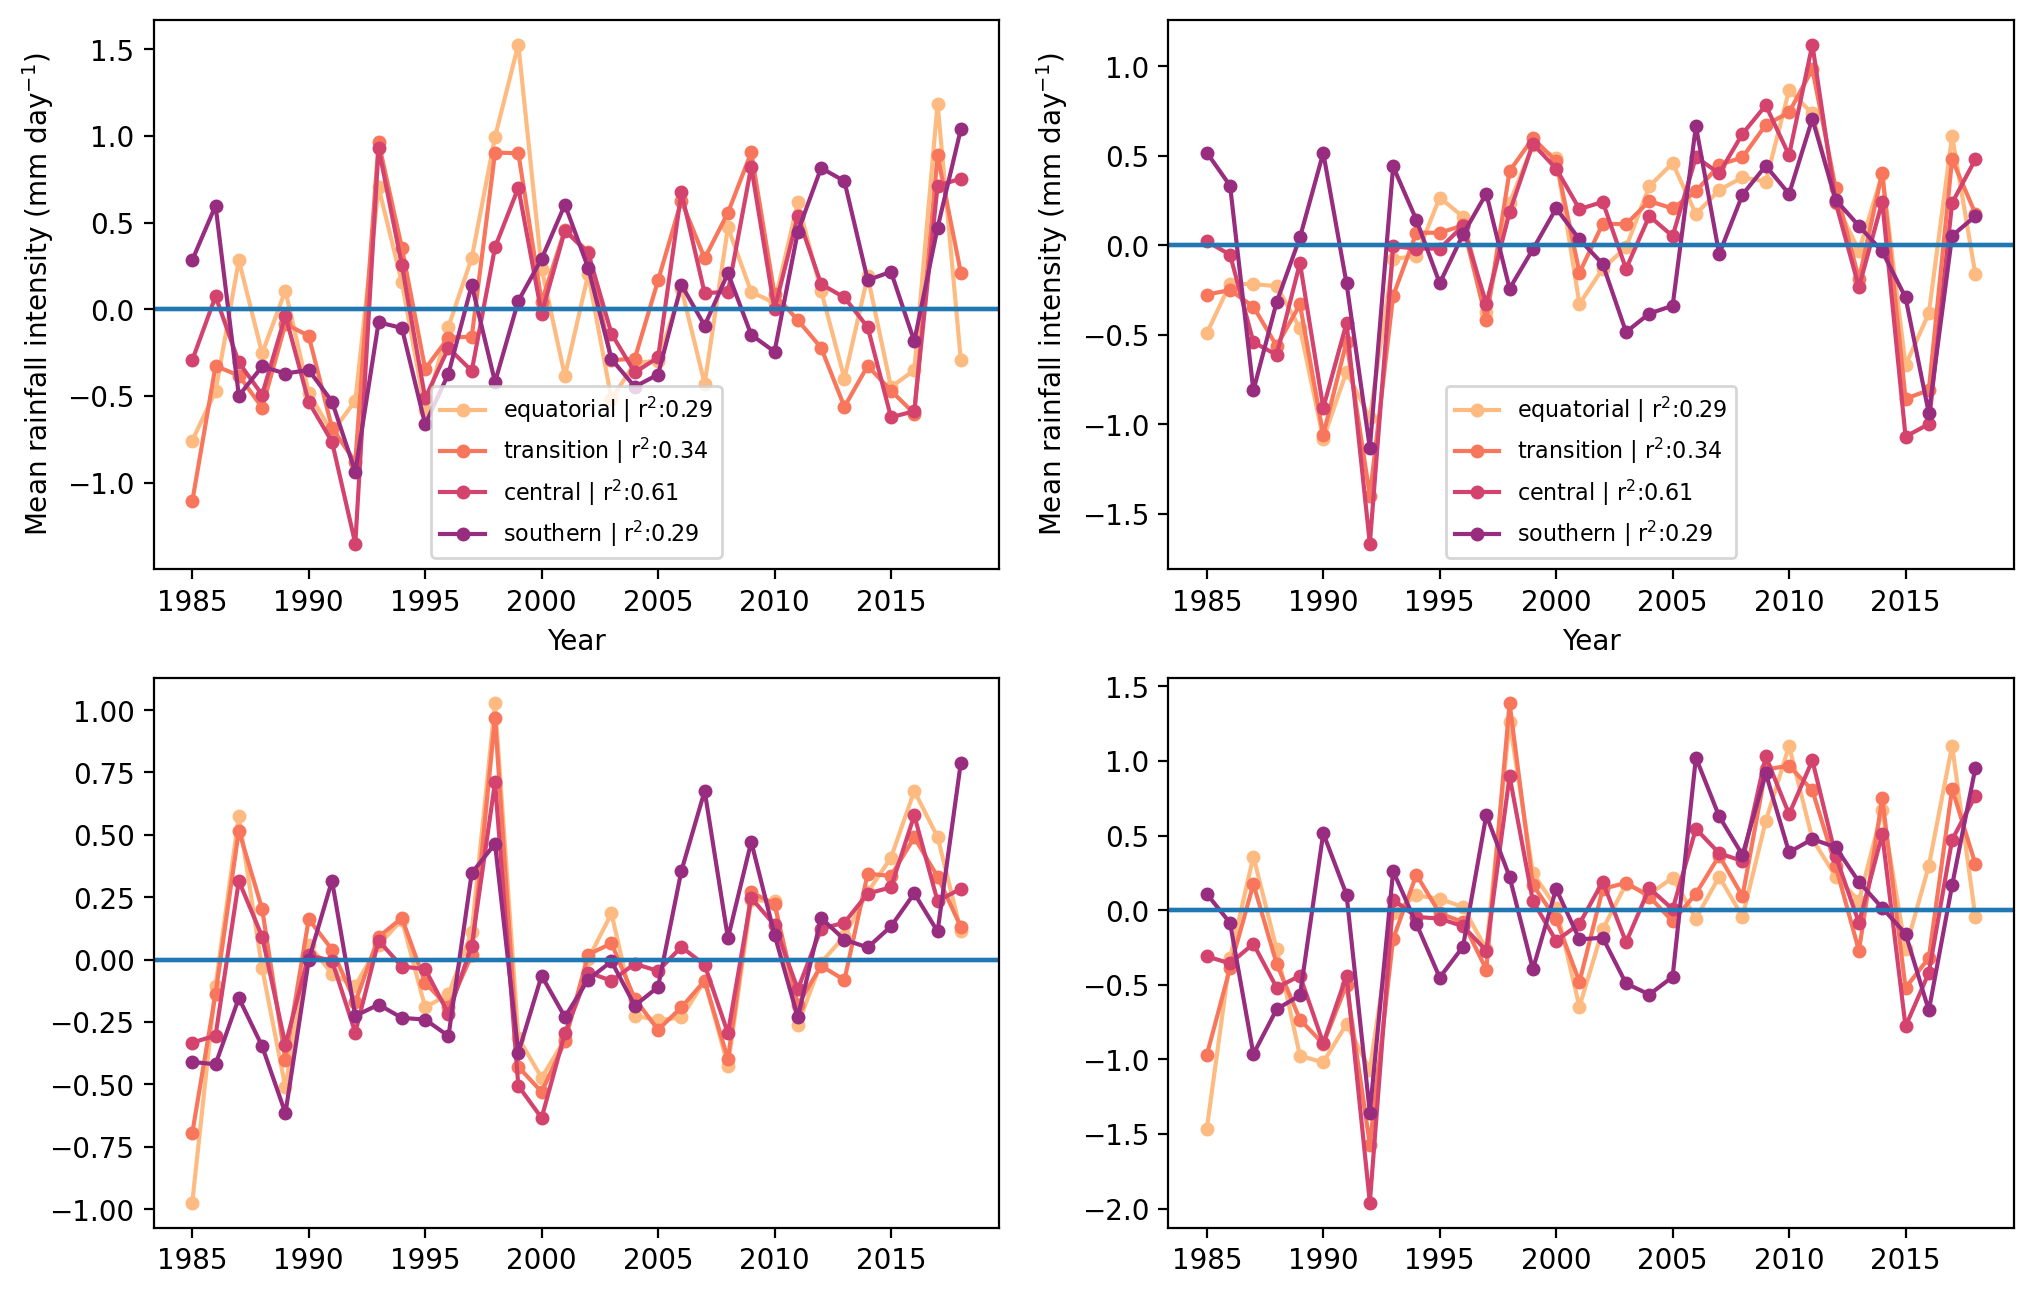

In [81]:
from endgame import hist2d

f = plt.figure(figsize=(12,8), dpi=200)

ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)


for ids, r in enumerate(regions.keys()):
    
    #scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values]
    
    xxch = scadir[r][0]
    xxu2 = scadir[r][1]
    xxv8 = scadir[r][2]
    xxq8 = scadir[r][3]
    xxtc = scadir[r][4]
    
    xxch = xxch-np.mean(xxch)
    xxu2 = xxu2-np.mean(xxu2)
    xxv8 = xxv8 - np.mean(xxv8)
    xxq8 = xxq8 - np.mean(xxq8)
    xxtc = xxtc - np.mean(xxtc)
    
    
    newu2 = xxu2 * -0.23 #hist2d_slopes[0] +
    newq8 = xxtc * 0.4 
    
    isfin = np.isfinite(xxch) & np.isfinite(newu2)
    isfin2 = np.isfinite(xxch) & np.isfinite(newq8)
    ax.plot(allyears, xxch, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    ax.axhline(0)
    ax2.plot(allyears, newu2, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    ax2.axhline(0)
    ax3.plot(allyears, newq8, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newq8[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    ax3.axhline(0)
    ax4.plot(allyears, newu2+newq8, label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newq8[isfin])[0]**2,2)), marker='o', markersize=4, color=colord[ids])
    ax4.axhline(0)
    

    ax.set_xlabel('Year')
    ax2.set_xlabel('Year')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax2.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')

    
#     hist, count, h = u_stats.histo_frequency(chirps_region.values[mask], bins=np.arange(0,20,0.1))
#     ax3.plot(np.arange(0,19.9,0.1),hist, label=r, color=colord[ids])
#     ax3.set_yscale('log')
    
ax.legend(fontsize=8)
ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()

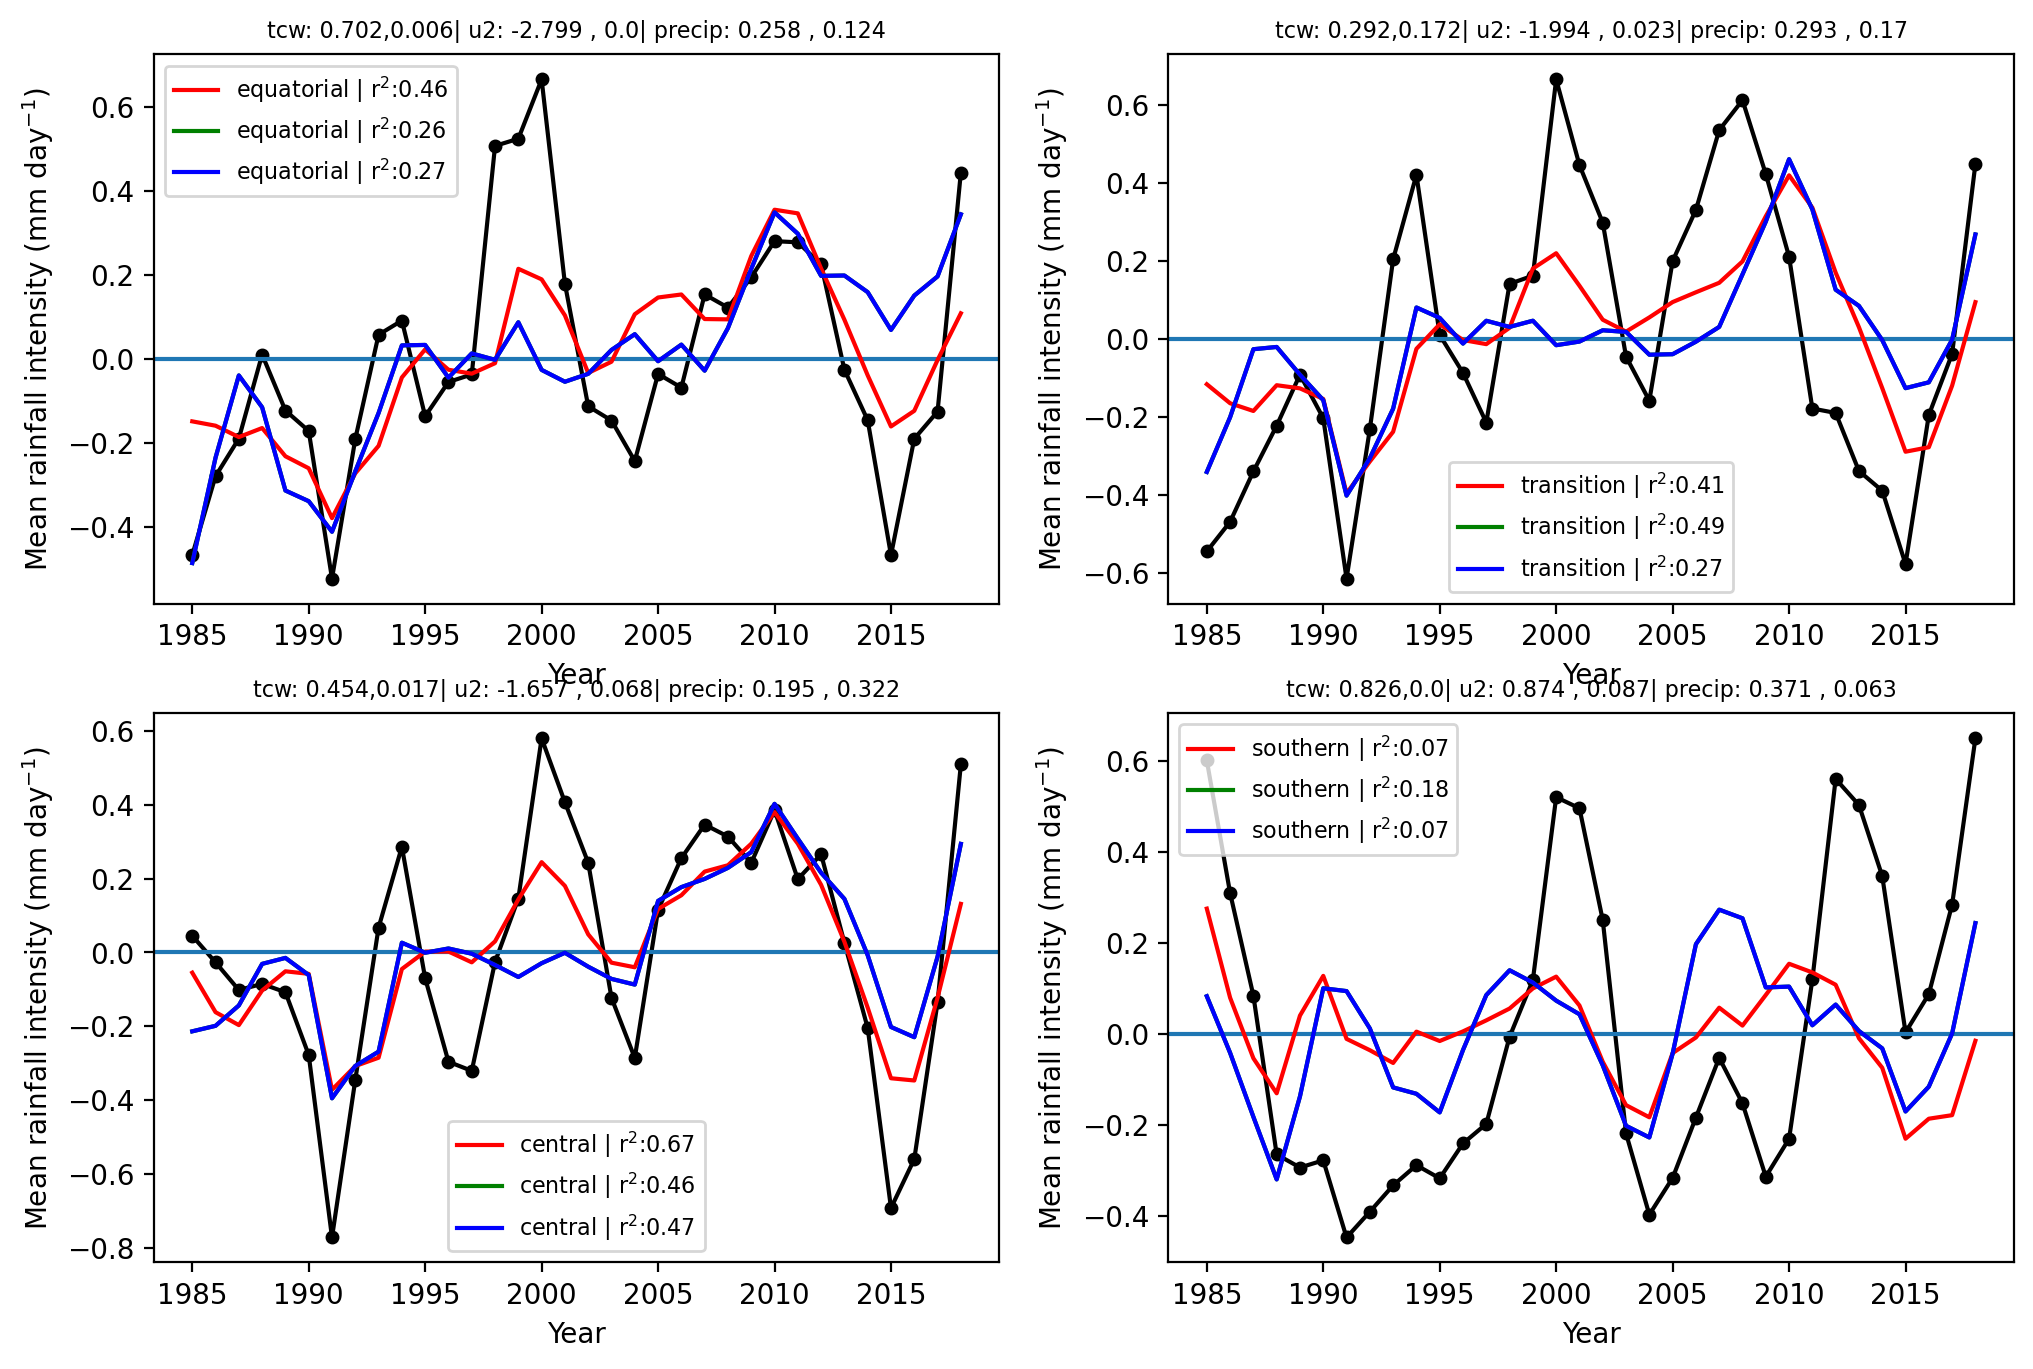

In [112]:
from endgame import hist2d

f = plt.figure(figsize=(12,8), dpi=200)


for ids, r in enumerate(regions.keys()):
    
    #scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values]
    
    ax = f.add_subplot(2,2,ids+1)
    
    xxch = filtdir[r][0]
    xxu2 = filtdir[r][1]
    xxtc = filtdir[r][2]
    xxgr = filtdir[r][3]
    
    xxch = xxch-np.mean(xxch)
    xxu2 = xxu2-np.mean(xxu2)
    xxtc = xxtc - np.mean(xxtc)
    xxgr = xxgr - np.mean(xxgr)
    
    
    newu2 = xxu2 * -0.13 #hist2d_slopes[0] +
    newq8 = xxtc *0.3
    
    isfin = np.isfinite(xxch) & np.isfinite(newu2)
    isfin2 = np.isfinite(xxch) & np.isfinite(newq8)
    ax.plot(allyears, xxch, marker='o', markersize=4, color='k')
    ax.axhline(0)
    
    slopet, interceptt, rrt, pt, k = linregress(allyears, xxtc)
    slope, intercept, rr, p, k  = linregress(allyears, xxch)
    slopeu, dum,dum, pu, dum  = linregress(allyears, xxu2)
    
    ax.plot(allyears, newu2, color='r', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2[isfin])[0]**2,2)))
    #ax.plot(allyears, newq8, color='orange', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newq8[isfin])[0]**2,2)))
    ax.plot(allyears, newu2+newq8, color='green', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr((xxgr*-1)[isfin],newu2+newq8[isfin])[0]**2,2)) )
    ax.plot(allyears, newu2+newq8, color='blue', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2+newq8[isfin])[0]**2,2)) )

    
    
    plt.title('tcw: '+str(np.round(slopet*len(allyears),3))+','+str(np.round(pt,3))+'| u2: '+str(np.round(slopeu*len(allyears),3))+' , '+str(np.round(pu,3))+'| precip: '+str(np.round(slope*len(allyears),3))+' , '+str(np.round(p,3)), fontsize=8)
    
#     ax1 = ax.twinx()
#     ax1.plot(allyears, xxgr*-1, color='green')
    

    ax.set_xlabel('Year')

    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')

    ax.legend(fontsize=8)


In [78]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

-0.14179636517871202 0.34063916880968936
-0.11690231584628787 0.3667530337106205
-0.11962491481205911 0.3704585311619816
-0.14682871822664773 0.1862887788955046


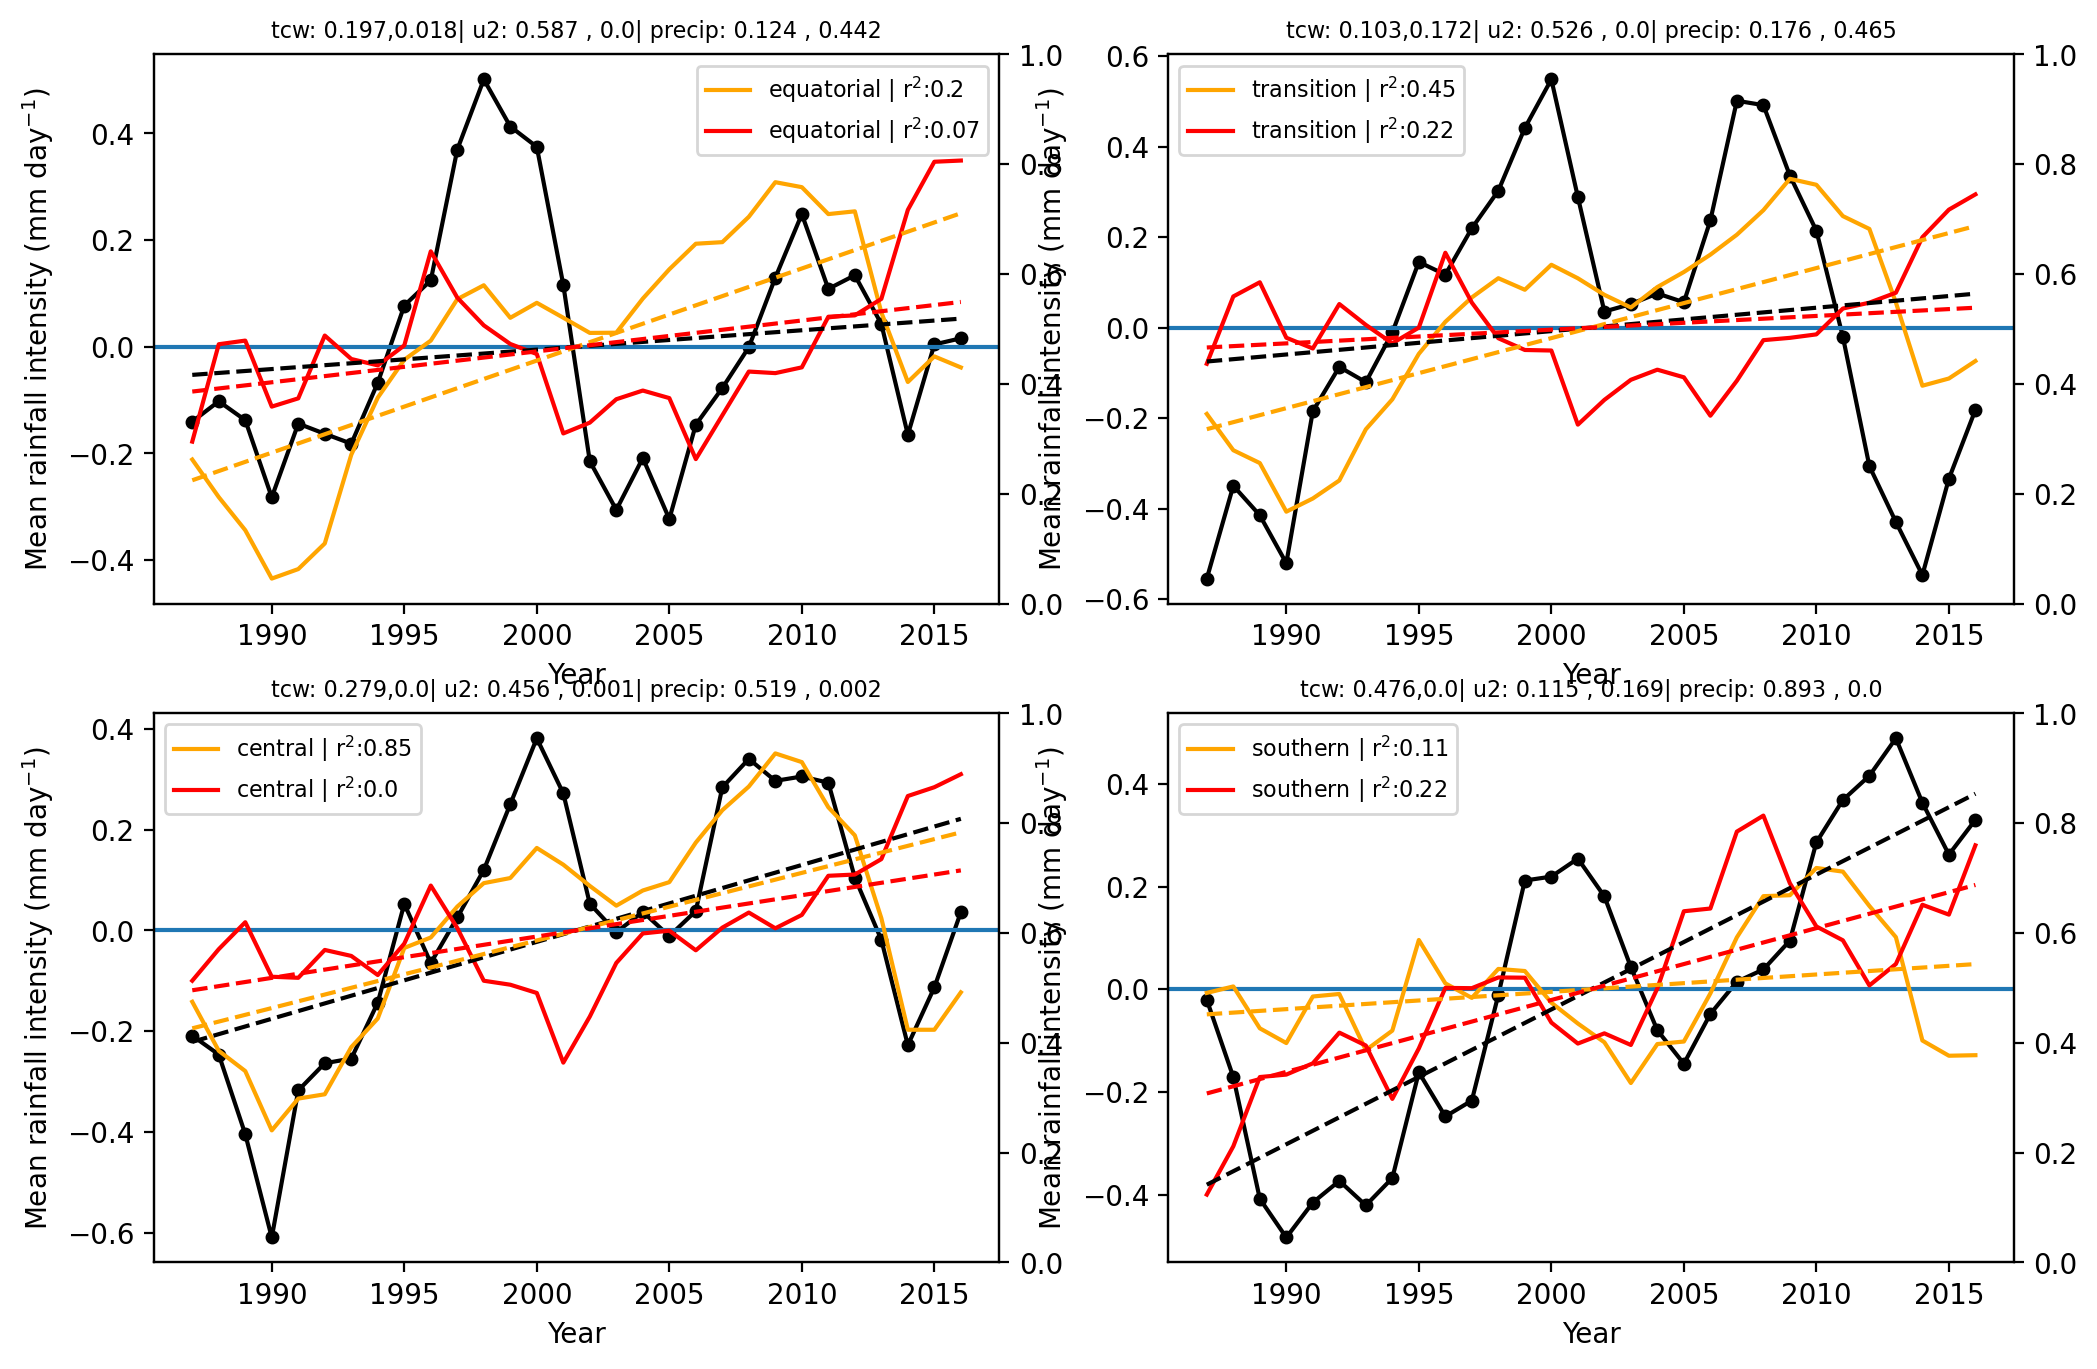

In [83]:
from endgame import hist2d

f = plt.figure(figsize=(12,8), dpi=200)


for ids, r in enumerate(regions.keys()):
    
    #scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values]
    
    ax = f.add_subplot(2,2,ids+1)
    
    
    statsi = slopes2d[r]
    slopeu = statsi[0]
    slopet = statsi[1]
    inter = statsi[2]
    
    xxch = moving_average(scadir[r][0],5)
    xxu2 = moving_average(scadir[r][1],5)
    xxv8 = moving_average(scadir[r][2],5)
    xxq8 = moving_average(scadir[r][3],5)
    xxtc = moving_average(scadir[r][4],5)
    
    allyears2 = moving_average(allyears,5)
    
    xxch = xxch-np.mean(xxch)
    xxu2 = xxu2-np.mean(xxu2)
    xxv8 = xxv8 - np.mean(xxv8)
    xxq8 = xxq8 - np.mean(xxq8)
    xxtc = xxtc - np.mean(xxtc)
    

    print(slopeu, slopet)
    new =  xxtc * 0.35
    newu2 = xxu2 *slopeu #hist2d_slopes[0] +
    newq8 = xxtc *0.3
    
    slopet, interceptt, rrt, pt, k = linregress(allyears2, newq8)
    slope, intercept, rr, p, k  = linregress(allyears2, xxch)
    slopeu, interceptu,dum, pu, dum  = linregress(allyears2, newu2)
    
    isfin = np.isfinite(xxch) & np.isfinite(newu2)
    isfin2 = np.isfinite(xxch) & np.isfinite(newq8)
    ax.plot(allyears2, xxch, marker='o', markersize=4, color='k')
    ax.axhline(0)
    ax2 = ax.twinx()
    ax.plot(allyears2, newu2, color='orange', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2[isfin])[0]**2,2)))
    ax.plot(allyears2, new, color='r', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], new[isfin])[0]**2,2)))
    #ax.plot(allyears, newq8, color='orange', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newq8[isfin])[0]**2,2)))
    #ax.plot(allyears, newu2+newq8, color='blue', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2+newq8[isfin])[0]**2,2)) )
    #ax2.plot(allyears, xxu2*-1, color='blue', label=r+" | r$^{2}$:"+str(np.round(stats.pearsonr(xxch[isfin], newu2+newq8[isfin])[0]**2,2)) )
    
    #print(slope, slopet)
    
        
    ax.plot(allyears2, allyears2*slope+intercept, linestyle='dashed', color='k')
    ax.plot(allyears2, allyears2*slopeu+interceptu, linestyle='dashed', color='orange')
    ax.plot(allyears2, allyears2*slopet+interceptt, linestyle='dashed', color='r')
    
    plt.title('tcw: '+str(np.round(slopet*len(allyears),3))+','+str(np.round(pt,3))+'| u2: '+str(np.round(slopeu*len(allyears),3))+' , '+str(np.round(pu,3))+'| precip: '+str(np.round(slope*len(allyears),3))+' , '+str(np.round(p,3)), fontsize=8)
    

    ax.set_xlabel('Year')
    ax.set_ylabel('Mean rainfall intensity (mm day$^{-1}$)')
    ax.legend(fontsize=8)



In [63]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [64]:
bardir = {}
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    era_region = u200ca['u'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e)))
    tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    chirps_region = cau200.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e)))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()

    xxtcw = tcwv_region.mean(['latitude', 'longitude'])#.groupby(tcwv_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    
    bardir[r] = [xxch, xxu2, xxtcw]

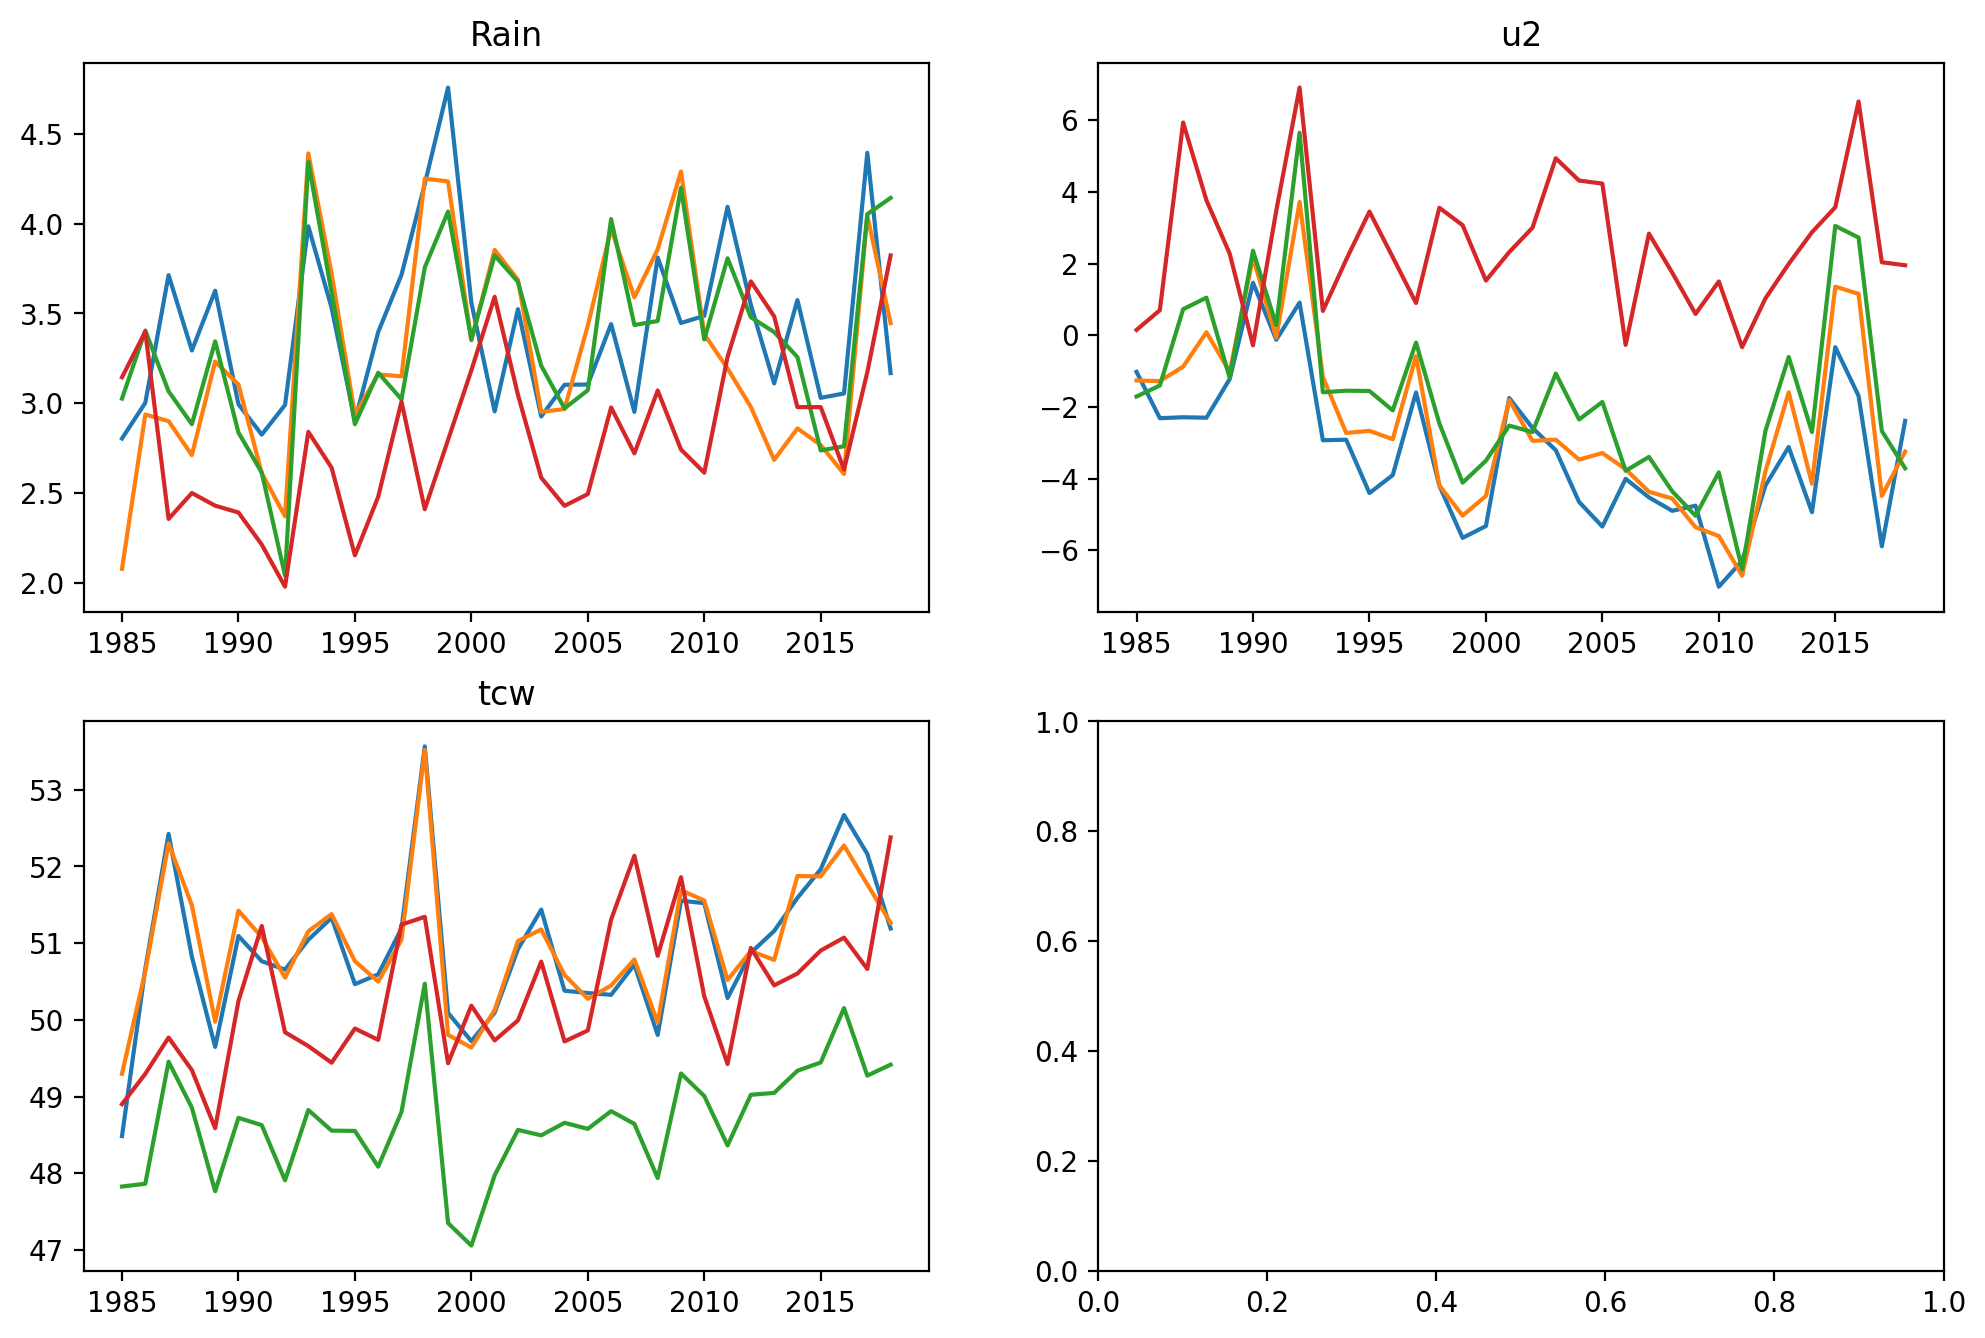

In [86]:
from endgame import hist2d


barlist = []
dbarlist = []
wbarlist = []
dplist = []
wplist = []

errlist = []
yearlist = []
slopeerr = []
rlist = []
plist = []

nyears = 10 #len(allyears) #10

f = plt.figure(figsize=(12,8), dpi=200)
ax = f.add_subplot(2,2,1)
ax1 = f.add_subplot(2,2,2)
ax2 = f.add_subplot(2,2,3)
ax3 = f.add_subplot(2,2,4)

for ids, r in enumerate(regions.keys()):
    
    #scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values]
    
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_v2.p", "rb"))
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))

    dd = dic['dry3']
    ww = dic['wet3']
    
   # ax = f.add_subplot(2,2,ids+1)

    statsi = slopes2d[r]
    slopeu = statsi[0]
    slopet = statsi[1]
    inter = statsi[2]
    
    
    xxch = bardir[r][0]
    xxu2 = bardir[r][1]
    xxtc = bardir[r][2]
    
    ych = xxch.groupby('time.year').mean('time')#.rolling(year=3, min_periods=1, center=True).mean()
    yu2 = xxu2.groupby('time.year').mean('time')#.rolling(year=3, min_periods=1, center=True).mean()
    ytc = xxtc.groupby('time.year').mean('time')#.rolling(year=3, min_periods=1, center=True).mean()
    
    ispos = np.intersect1d(dd,xxch.time)
    ychd = xxch.sel(time=ispos).groupby('time.year').mean('time')#.rolling(year=2, min_periods=1, center=True).mean()
    ispos = np.intersect1d(dd,xxu2.time)
    yu2d = xxu2.sel(time=ispos).groupby('time.year').mean('time')#.rolling(year=2, min_periods=1, center=True).mean()
    ispos = np.intersect1d(dd,xxtc.time)
    ytcd = xxtc.sel(time=ispos).groupby('time.year').mean('time')#.rolling(year=2, min_periods=1, center=True).mean()
    
    ispos = np.intersect1d(ww,xxch.time)
    ychw = xxch.sel(time=ispos).groupby('time.year').mean('time')#.rolling(year=2, min_periods=1, center=True).mean()
    ispos = np.intersect1d(ww,xxu2.time)
    yu2w = xxu2.sel(time=ispos).groupby('time.year').mean('time')#.rolling(year=2, min_periods=1, center=True).mean()
    ispos = np.intersect1d(ww,xxtc.time)
    ytcw = xxtc.sel(time=ispos).groupby('time.year').mean('time')#.rolling(year=2, min_periods=1, center=True).mean()
    
    ax.plot(ychw.year, ych)
    ax.set_title('Rain')
    ax1.plot(yu2w.year, yu2)
    ax1.set_title('u2')
    ax2.plot(ytcw.year, ytc)
    ax2.set_title('tcw')
    
    #daybasis
    
    chstd = np.std(xxch)
    u2std = np.std(xxu2) * slopeu
    tcstd = np.std(xxtc) * slopet
    bothstd = u2std + tcstd
    
    #ybasis
    if r == 'southern':
        slopet = (slopes2d['central'])[1]
    
    ychstd = np.std(ych)
    yu2std = np.std(yu2) * slopeu
    ytcstd = np.std(ytc) * slopet
    bothstd = yu2std + ytcstd
    
    #trends

    stc, interceptc, rrc, pc, sec = linregress(allyears, ych)
    stu, interceptu, rru, pu, seu  = linregress(allyears, yu2)
    stt, interceptt, rrt, pt, sett  = linregress(allyears, ytc)
    
    trendc = stc*nyears
    trendu = stu*nyears * slopeu
    trendt = stt*nyears * slopet
    
    # dry trends
    
    stcd, interceptcd, rrcd, pcd, secd = linregress(np.unique(ychd['year']), ychd)
    stud, interceptud, rrud, pud, seud  = linregress(np.unique(yu2d['year']), yu2d)
    sttd, intercepttd, rrtd, ptd, settd  = linregress(np.unique(ytcd['year']), ytcd)
    
    trendc_d = stcd*nyears
    trendu_d = stud*nyears * slopeu
    trendt_d = sttd*nyears * slopet
    
    # wet trends
    
    stcw, interceptcw, rrcw, pcw, secw = linregress(np.unique(ychw['year']), ychw)
    stuw, interceptuw, rruw, puw, seuw  = linregress(np.unique(yu2w['year']), yu2w)
    sttw, intercepttw, rrtw, ptw, settw  = linregress(np.unique(ytcw['year']), ytcw)
    
    trendc_w = stcw*nyears
    trendu_w = stuw*nyears * slopeu
    trendt_w = sttw*nyears * slopet
    
    barlist.append( (trendc, trendu, trendt))
    errlist.append( (chstd, u2std,tcstd))
    yearlist.append( (ychstd, yu2std,ytcstd))
    slopeerr.append( (sec*nyears, seu*nyears*slopeu,sett*nyears*slopet))
    rlist.append((rrc, rru, rrt))
    plist.append((pc, pu, pt))
    
    dplist.append((pcd, pud, ptd))
    wplist.append((pcw, puw, ptw))
    dbarlist.append( (trendc_d, trendu_d, trendt_d))
    wbarlist.append( (trendc_w, trendu_w, trendt_w))

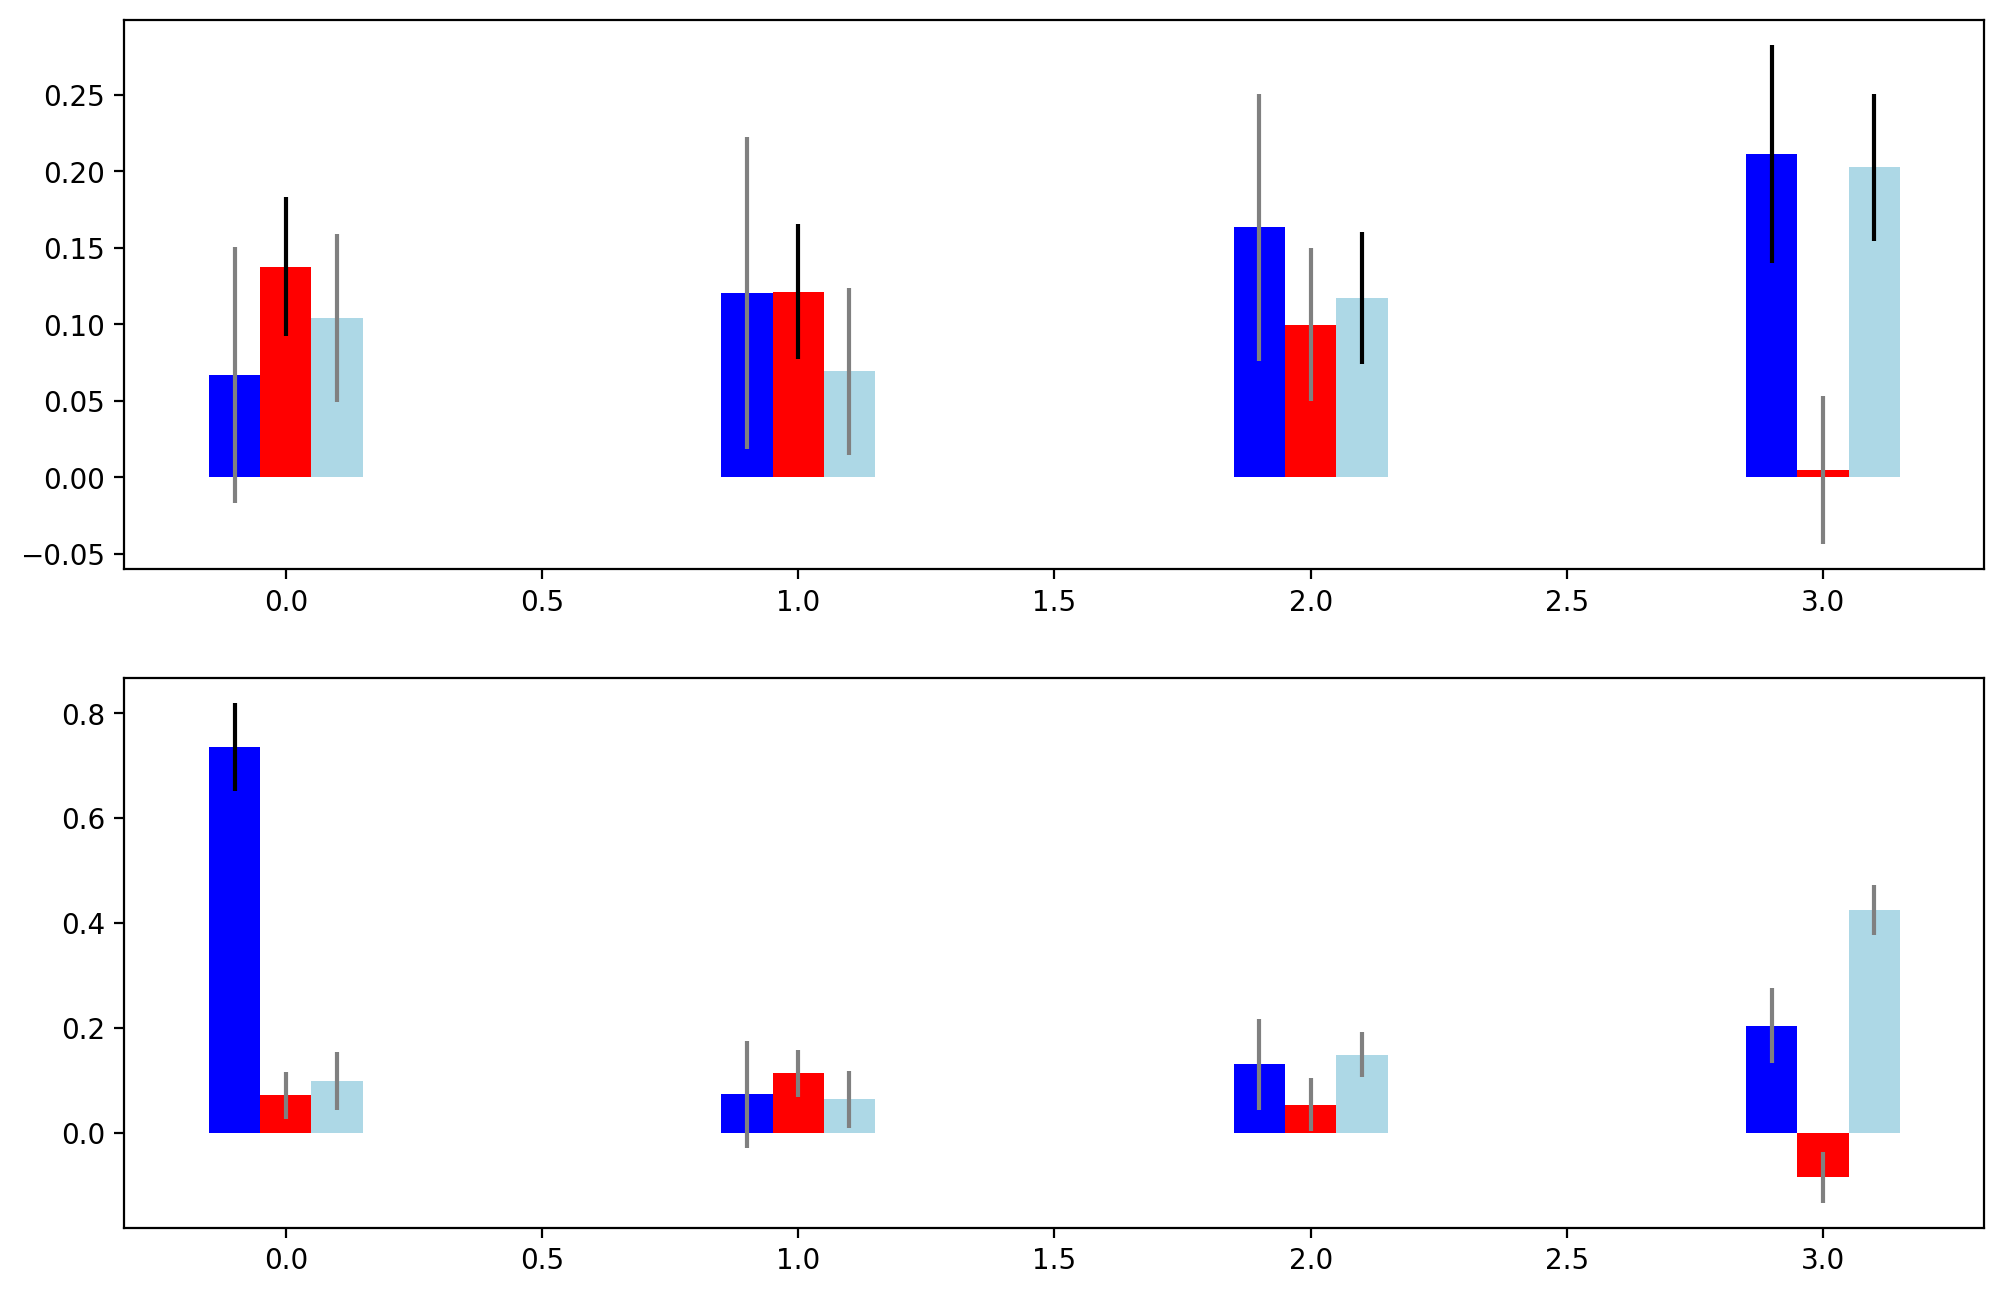

In [87]:
f = plt.figure(figsize=(12,8), dpi=200)

ax = f.add_subplot(211)
ax1 = f.add_subplot(212)

shi = [-0.1,0,0.1,0.2]

for ids, r in enumerate(regions.keys()):
    
    bplot = barlist[ids]
    eplot = slopeerr[ids]
    sigplot = plist[ids]
    sigpos = np.where(np.array(sigplot)<=0.05)
    colors = np.array(['grey']*4)
    colors[sigpos] = 'k'
    
    bar1 = ax.bar(ids+shi[0], bplot[0], color='b', width=0.1, yerr=eplot[0], linewidth=0.5, ecolor=colors[0])
    bar2 = ax.bar(ids+shi[1], bplot[1], color='r', width=0.1, yerr=eplot[1], ecolor=colors[1])
    bar3 = ax.bar(ids+shi[2], bplot[2], color='lightblue', width=0.1, yerr=eplot[2], ecolor=colors[2])
    #bar4 = ax.bar(ids+shi[3], bplot[3], color='b', width=0.1, yerr=eplot[3], ecolor=colors[3])
    
    bplot = wbarlist[ids]
    sigplot = wplist[ids]
    sigpos = np.where(np.array(sigplot)<=0.05)
    colors = np.array(['grey']*4)
    colors[sigpos] = 'k'
    bar1 = ax1.bar(ids+shi[0], bplot[0], color='b', width=0.1, yerr=eplot[0], linewidth=0.5, ecolor=colors[0])
    bar2 = ax1.bar(ids+shi[1], bplot[1], color='r', width=0.1, yerr=eplot[1], ecolor=colors[1])
    bar3 = ax1.bar(ids+shi[2], bplot[2], color='lightblue', width=0.1, yerr=eplot[2], ecolor=colors[2])
    
    

In [119]:
allreg_dry = []
allreg_wet = []

for pr in ['equatorial', 'transition', 'central','southern']:
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+pr+"_dw_spellDates_0.15perc_v2.p", "rb"))
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+pr+"_dw_spellDates_0.15perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))
    dry = (dic['dry5'][(dic['dry5'].month>=13) | (dic['dry5'].month<=3)]).year
    wet = (dic['wet5'][(dic['wet5'].month>=13) | (dic['wet5'].month<=3)]).year
    
    allreg_dry.append(dry.values)
    allreg_wet.append(wet.values)

In [120]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

32 32
0.05348237485524664
0.06162676741341679
32 32
0.15524713425459735
0.02190935323183849
32 32
0.3288760704429732
0.7328708297495057
29 29
0.0261490304550894
0.4047483094576185


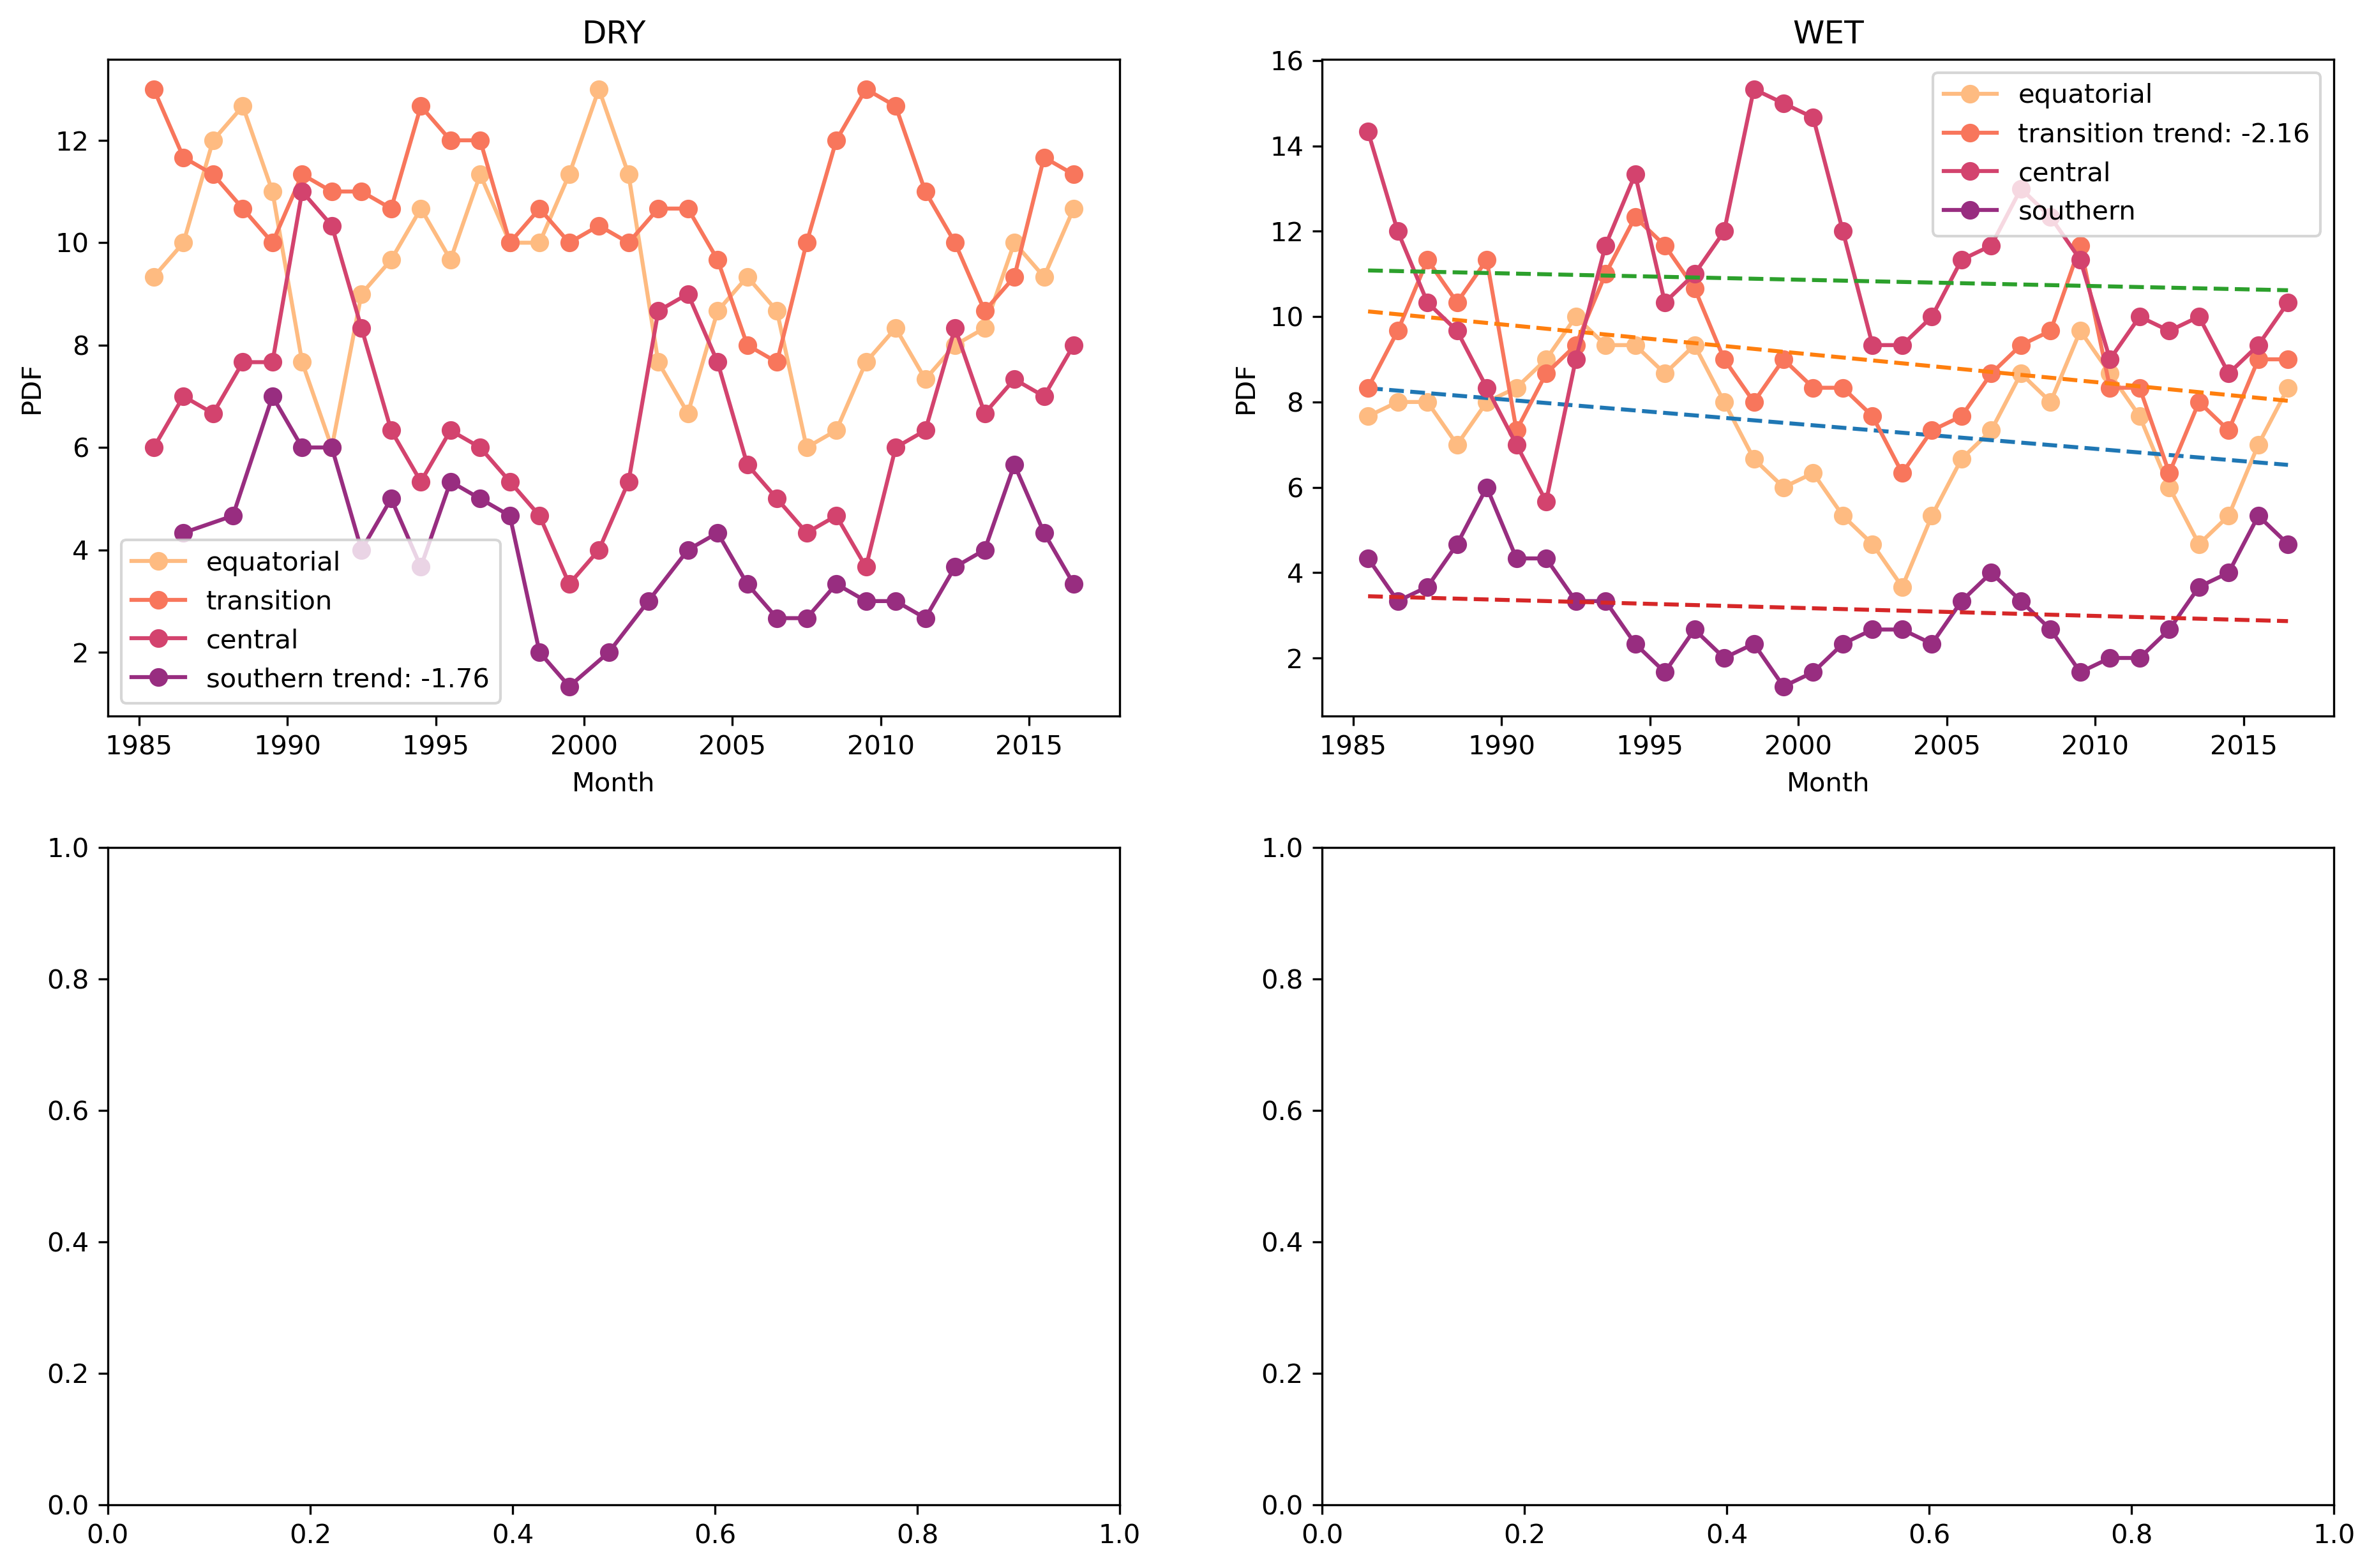

In [121]:
f = plt.figure(figsize=(15,10), dpi=300)
ax = f.add_subplot(221)
ax1 = f.add_subplot(222)
ax2 = f.add_subplot(223)
ax3 = f.add_subplot(224)
colors = sns.color_palette("magma_r") #[colord[0], colord[1], colord[2], colord[3]]
label = ['equatorial', 'transition', 'central','southern']

for ids, reg in enumerate(label):
    
    xxch = bardir[reg][0]
    xxu2 = bardir[reg][1]
    xxq8 = bardir[reg][2]
    
    dy, dc = np.unique(allreg_dry[ids], return_counts=True)
    dy = moving_average(dy,3)
    dc = moving_average(dc,3)
    print(len(dy), len(dc))
    sloped, interceptd, rd, pd, kd = linregress(dy, dc)
    print(pd)
    if pd < 0.05:
        dtag = ' trend: '+str(np.round(sloped*len(dy), 2))
    else:
        dtag = ''
    ax.plot(dy-0.5, dc,  color=colors[ids], label=reg+dtag, marker='o')
   # ax.legend()
    ax.set_title('DRY')
    
    wy, wc = np.unique(allreg_wet[ids], return_counts=True)
    wy = moving_average(wy,3)
    wc = moving_average(wc,3)
    slopew, interceptw, rw, pw, kw = linregress(wy, wc)
    print(pw)
    if pw < 0.05:
        wtag = ' trend: '+str(np.round(slopew*len(wy), 2))
    else:
        wtag = ''
    ax1.plot(wy-0.5, wc,  color=colors[ids], label=reg+wtag, marker='o')
    ax1.plot(wy-0.5, interceptw+(wy-0.5)*slopew, linestyle='dashed')
    ax1.set_title('WET')
    
#     ax2.plot(allyears, (xxu2-np.mean(xxu2))*-1,  color=colors[ids])
#     ax3.plot(allyears, xxq8-np.mean(xxq8),  color=colors[ids])

    ax.set_xlabel('Month')
    ax1.set_xlabel('Month')

    ax.set_ylabel('PDF')
    ax1.set_ylabel('PDF')
#     ax.axhline(0)
#     ax1.axhline(0)
    
ax.legend()
ax1.legend()

In [98]:
## all regions pure daily (day by day, no histogram averaging) multivariate regression

from mpl_toolkits.mplot3d import Axes3D
import pandas
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import wls
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
# Convert the data into a Pandas DataFrame to use the formulas framework
# in statsmodels

reg = 'transition'

X = var1
Y = var2
Z = xxch

data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
weight = [1]*len(var1)
# Fit the model
model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

# Print the summary
print(model.summary())

#print("\nRetrieving manually the parameter estimates:")
print(model._results.params)
# should be array([-4.99754526,  3.00250049, -0.50514907])

# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.285
Model:                            WLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     3101.
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:38:51   Log-Likelihood:                -35612.
No. Observations:               15528   AIC:                         7.123e+04
Df Residuals:                   15525   BIC:                         7.125e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6211      0.059     27.466      0.0